In [72]:
import pandas as pd
from glob import glob
from scipy.stats import mannwhitneyu
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import itertools
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

import networkx as nx
from matplotlib.colors import LinearSegmentedColormap


from scipy.stats import wilcoxon
from statsmodels.stats.multitest import multipletests


In [1]:
# ! pip install -U scikit-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 9.3 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.2/302.2 kB 11.7 MB/s eta 0:00:00


In [27]:
# get path to csv file, mouse IDs and relevant timepoints
path = '/Volumes/lab-kohlj/home/shared/people/Irene/sensitization/BORIS project/scored/'
IDs = ["BRAC7159.2d", "BRAC7172.1e", "BRAC7172.1g", "BRAC7172.1h", "BRAC7266.1i", "BRYD63.4c", "BRYD65.4f", "BRYA125.3i", "BRYB121.3g", "BRYC103.3f"]
times = ["baseline","day1", "day2", "day3","day4"]

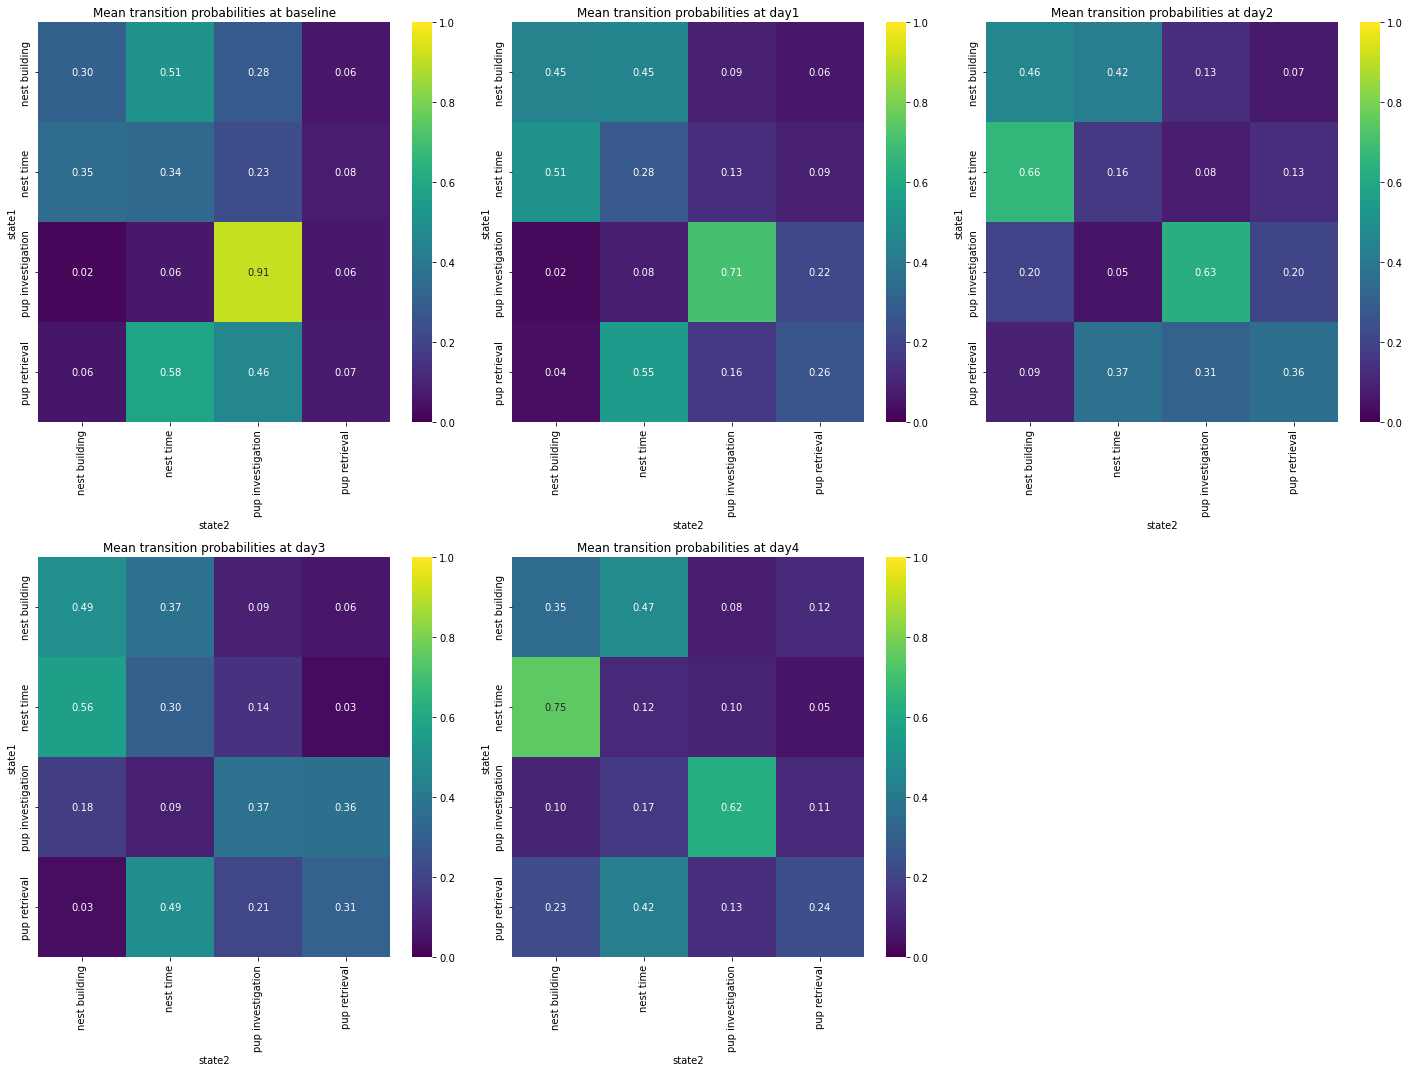

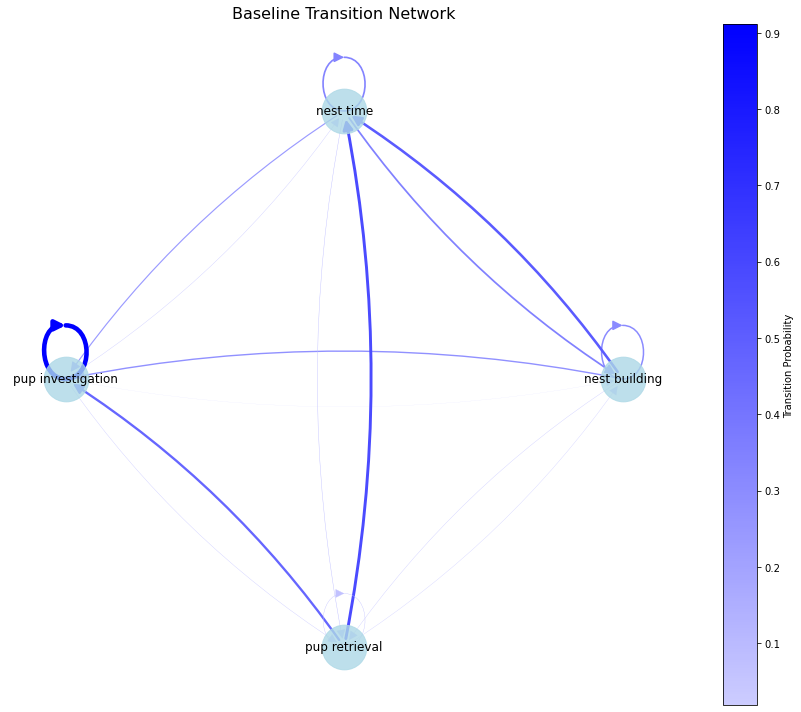

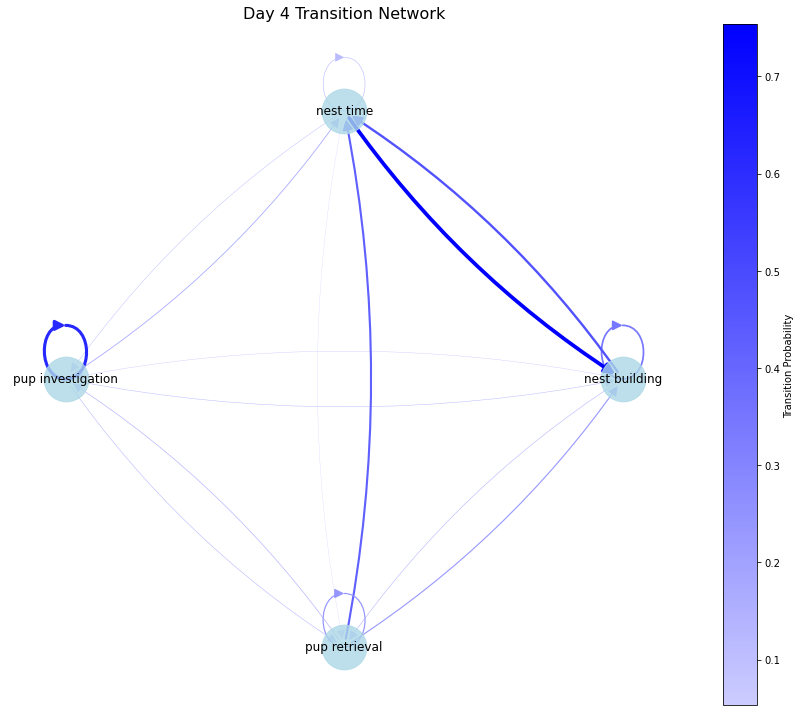

In [ ]:
# NEW CODE
# First ensure we have networkx installed
# !pip install networkx

# Create transition matrices for each mouse at each timepoint
transition_matrices_list = []

for ID in IDs:
    for time in times:
        try:
            file = glob(path + f'{ID}_virgin_{time}_scored*.csv')
            bdf = pd.read_csv(file[0])
            
            # Organize imported dataframe
            bdf = bdf.iloc[14:, :]
            columns = list(bdf.iloc[0])
            bdf.columns = columns
            bdf = bdf.iloc[1:, :]
            bdf["Time"] = bdf["Time"].astype(float)
            
            # Drop rows with behaviors defined as 'who knows', 'pup intro', 'end trial', and 'crouching'
            bdf = bdf[~bdf.Behavior.isin(['who knows', 'pup intro', 'end trial', 'crouching'])]
            
            # Filter aborted retrieval and retrieval to nest as pup retrieval
            bdf.loc[bdf.Behavior.isin(['aborted retrieval', 'retrieval to nest']), 'Behavior'] = 'pup retrieval'
            
            # Filter pup sniff and pup groom as pup investigation
            bdf.loc[bdf.Behavior.isin(['pup sniff', 'pup groom']), 'Behavior'] = 'pup investigation'
            
            # Calculate transition matrix for each animal
            sequence = bdf[bdf.Status == 'START'].Behavior.tolist()
            T = pd.crosstab(
                pd.Series(sequence[:-1], name='state1'),  # crosstab index
                pd.Series(sequence[1:], name='state2'),   # crosstab columns
                normalize='index')  # normalize by row
            
            # Add ID and time columns
            T['ID'] = ID
            T['Time'] = time
            
            # Add to list
            transition_matrices_list.append(T)
            
        except IndexError:
            print(f'Error loading {ID}_virgin_{time}_scored*.csv')
            continue

# Combine all transition matrices
transition_matrices = pd.concat(transition_matrices_list)

# Calculate mean transition matrices for each timepoint
mean_matrices = {}
for time in times:
    time_matrix = transition_matrices[transition_matrices.Time == time]
    # Exclude non-numeric columns when calculating the mean
    numeric_cols = time_matrix.select_dtypes(include=[np.number]).columns.tolist()
    mean_matrices[time] = time_matrix.groupby('state1')[numeric_cols].mean()

# Visualize heatmaps for each timepoint
plt.figure(figsize=(20, 15))
for i, time in enumerate(times, 1):
    plt.subplot(2, 3, i)
    sns.heatmap(mean_matrices[time], cmap='viridis', annot=True, fmt=".2f", vmin=0, vmax=1)
    plt.title(f'Mean transition probabilities at {time}')

plt.tight_layout()
plt.savefig('plots/all_timepoints_heatmaps.png', dpi=300, bbox_inches='tight')
plt.show()

# Create network graphs for baseline and day4
def create_transition_graph(transition_matrix, title):
    # Create directed graph
    G = nx.DiGraph()
    
    # Add nodes (behaviors)
    behaviors = transition_matrix.index
    for behavior in behaviors:
        G.add_node(behavior)
    
    # Add edges with weights based on transition probabilities
    for source in behaviors:
        for target in transition_matrix.columns:
            if target in ['ID', 'Time']:  # Skip non-behavior columns
                continue
            
            # Get transition probability
            prob = transition_matrix.loc[source, target]
            
            # Only add edges with non-zero probability
            if prob > 0:
                G.add_edge(source, target, weight=prob, width=prob*5)
    
    # Create plot
    plt.figure(figsize=(12, 10))
    
    # Position nodes in a circle
    pos = nx.circular_layout(G)
    
    # Draw nodes
    nx.draw_networkx_nodes(G, pos, node_size=2000, node_color='lightblue', alpha=0.8)
    
    # Draw node labels
    nx.draw_networkx_labels(G, pos, font_size=12)
    
    # Get edge weights for line thickness and color intensity
    edge_weights = [G[u][v]['weight'] for u, v in G.edges()]
    
    # Create custom colormap for edges (from light to dark blue)
    edge_cmap = LinearSegmentedColormap.from_list("edge_colormap", ["#CCCCFF", "#0000FF"])
    
    # Draw edges with varying thickness and color based on weight
    nx.draw_networkx_edges(
        G, pos, 
        width=[w*5 for w in edge_weights],  # Scale up for visibility
        edge_color=edge_weights,
        edge_cmap=edge_cmap,
        edge_vmin=min(edge_weights),
        edge_vmax=max(edge_weights),
        arrowsize=20,
        connectionstyle='arc3,rad=0.1'  # Curved edges for clearer visualization
    )
    
    # Add colorbar
    sm = plt.cm.ScalarMappable(cmap=edge_cmap, norm=plt.Normalize(min(edge_weights), max(edge_weights)))
    sm.set_array([])
    cbar = plt.colorbar(sm)
    cbar.set_label('Transition Probability')
    
    plt.title(title, fontsize=16)
    plt.axis('off')
    plt.tight_layout()
    
    return plt

# Create and save network graphs for baseline and day4
baseline_graph = create_transition_graph(mean_matrices['baseline'], 'Baseline Transition Network')
baseline_graph.savefig('plots/baseline_transition_network.png', dpi=300, bbox_inches='tight')

day4_graph = create_transition_graph(mean_matrices['day4'], 'Day 4 Transition Network')
day4_graph.savefig('plots/day4_transition_network.png', dpi=300, bbox_inches='tight')

plt.show()

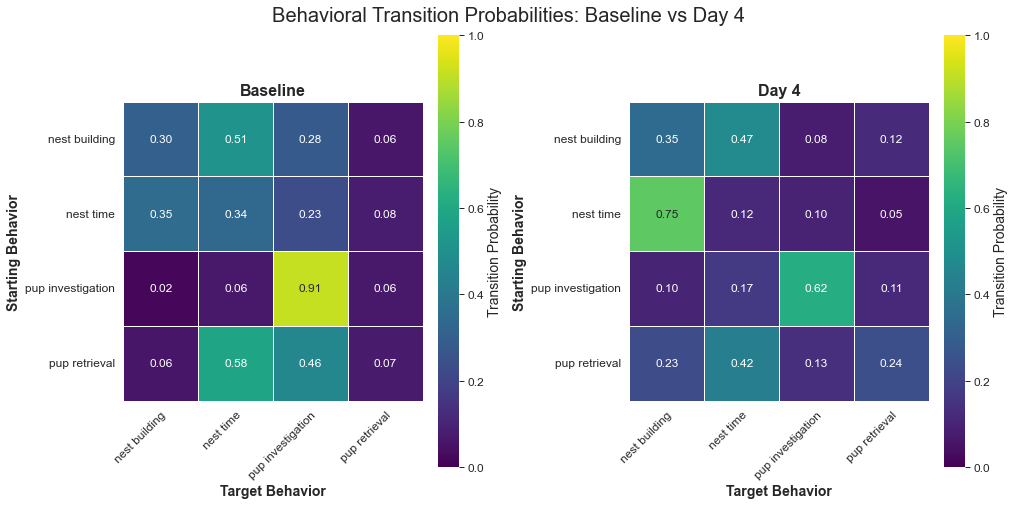

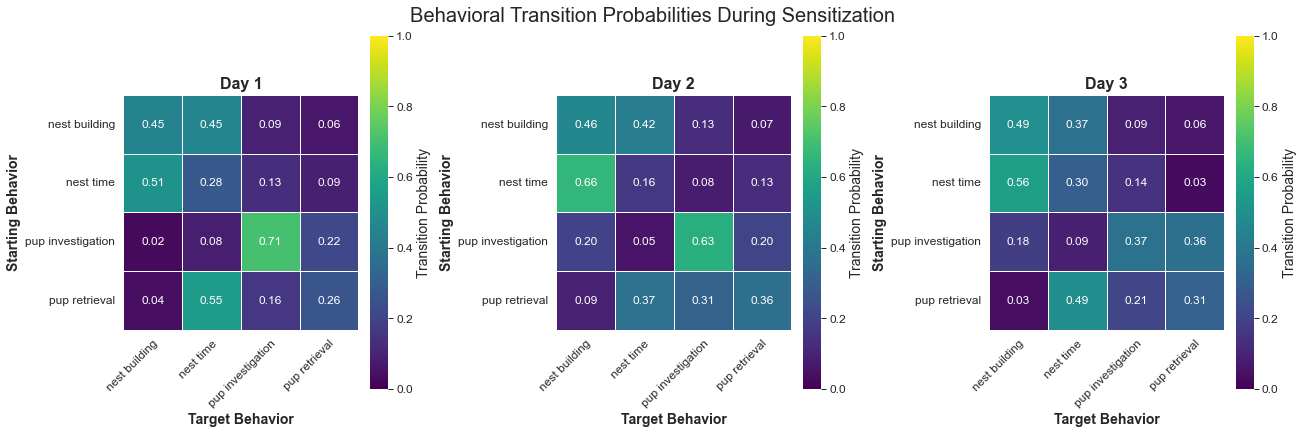

In [47]:
## Code for publication-ready figures
# Set publication-ready styling
plt.rcParams.update({
    'font.family': 'sans-serif',
    'font.sans-serif': ['Arial'],
    'font.size': 12,
    'axes.labelsize': 14,
    'axes.titlesize': 16,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'legend.fontsize': 12,
    'figure.titlesize': 18
})

# Create transition matrices for each mouse at each timepoint
# ... [code for creating transition matrices remains the same] ...

# Define a colorblind-friendly colormap for all visualizations (consistent across plots)
cmap = sns.color_palette("viridis", as_cmap=True)

# Set up global vmin and vmax for consistent color scaling across all heatmaps
all_vals = np.concatenate([mat.values.flatten() for mat in mean_matrices.values()])
vmin = 0
vmax = 1  # Using fixed 0-1 range for transition probabilities

# PLOT 1: Baseline and Day 4 heatmaps side by side
fig1, axes1 = plt.subplots(1, 2, figsize=(14, 7), constrained_layout=True)
fig1.suptitle('Behavioral Transition Probabilities: Baseline vs Day 4', fontsize=20)

# Common function for creating square heatmaps
def create_square_heatmap(ax, matrix, title):
    # Create square heatmap with consistent styling
    sns.heatmap(
        matrix, 
        cmap=cmap, 
        annot=True, 
        fmt=".2f", 
        vmin=vmin, 
        vmax=vmax,
        linewidths=0.5,
        cbar_kws={'label': 'Transition Probability'},
        ax=ax,
        square=True  # Enforce square shape for cells
    )
    
    # Improve title and axis labels
    ax.set_title(title, fontweight='bold')
    ax.set_xlabel('Target Behavior', fontweight='bold')
    ax.set_ylabel('Starting Behavior', fontweight='bold')
    
    # Adjust tick label formatting
    plt.setp(ax.get_xticklabels(), rotation=45, ha='right', rotation_mode='anchor')
    plt.setp(ax.get_yticklabels(), rotation=0)

# Create baseline and day4 heatmaps
create_square_heatmap(axes1[0], mean_matrices['baseline'], 'Baseline')
create_square_heatmap(axes1[1], mean_matrices['day4'], 'Day 4')

# Save the first plot
plt.savefig('plots/baseline_vs_day4_heatmaps.png', dpi=600, bbox_inches='tight')
plt.show()

# PLOT 2: Day 1, Day 2, and Day 3 heatmaps in one row
fig2, axes2 = plt.subplots(1, 3, figsize=(18, 6), constrained_layout=True)
fig2.suptitle('Behavioral Transition Probabilities During Sensitization', fontsize=20)

# Create heatmaps for remaining days
create_square_heatmap(axes2[0], mean_matrices['day1'], 'Day 1')
create_square_heatmap(axes2[1], mean_matrices['day2'], 'Day 2')
create_square_heatmap(axes2[2], mean_matrices['day3'], 'Day 3')

# Save the second plot
plt.savefig('plots/training_days_heatmaps.png', dpi=600, bbox_inches='tight')
plt.show()


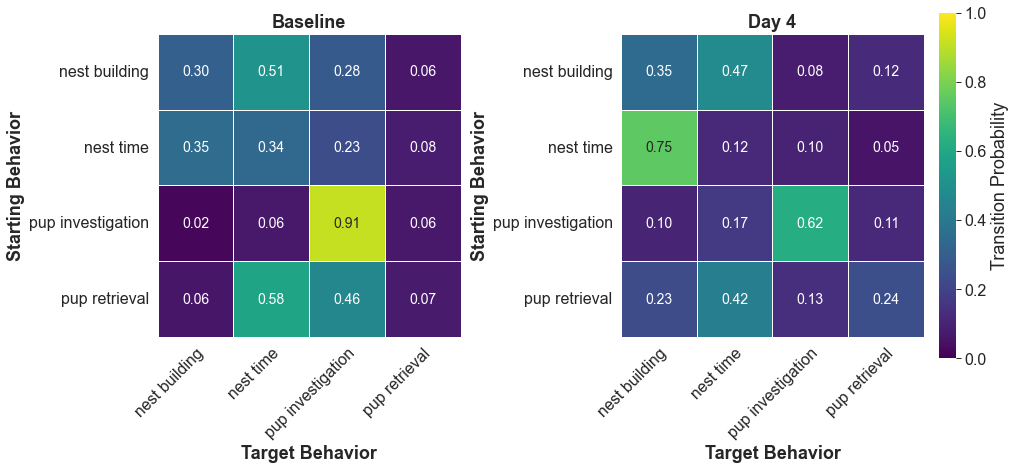

In [94]:
## Code for publication-ready figures
# Set publication-ready styling
plt.rcParams.update({
    'font.family': 'sans-serif',
    'font.sans-serif': ['Arial'],
    'font.size': 14,  # Increased base font size
    'axes.labelsize': 18,  # Increased from 14
    'axes.titlesize': 18,  # Increased from 16
    'xtick.labelsize': 16,  # Increased from 12
    'ytick.labelsize': 16,  # Increased from 12
    'legend.fontsize': 14,
    'figure.titlesize': 18
})

# Define a colorblind-friendly colormap for all visualizations (consistent across plots)
cmap = sns.color_palette("viridis", as_cmap=True)

# Set up global vmin and vmax for consistent color scaling across all heatmaps
all_vals = np.concatenate([mat.values.flatten() for mat in mean_matrices.values()])
vmin = 0
vmax = 1  # Using fixed 0-1 range for transition probabilities

# PLOT 1: Baseline and Day 4 heatmaps side by side
fig1, axes1 = plt.subplots(1, 2, figsize=(14, 7), constrained_layout=True)
# Removed suptitle as requested

# Common function for creating square heatmaps with option to control colorbar
def create_square_heatmap(ax, matrix, title, show_cbar=True):
    # Create square heatmap with consistent styling
    cbar_kws = {
        'label': 'Transition Probability',
        'shrink': 0.8,
        'aspect': 20,
        'ticks': [0, 0.2, 0.4, 0.6, 0.8, 1.0]
    } if show_cbar else None
    
    # Create the heatmap
    hm = sns.heatmap(
        matrix, 
        cmap=cmap, 
        annot=True, 
        fmt=".2f", 
        vmin=vmin, 
        vmax=vmax,
        linewidths=0.5,
        cbar=show_cbar,
        cbar_kws=cbar_kws,
        ax=ax,
        square=True,  # Enforce square shape for cells
        annot_kws={'size': 14}  # Increase annotation text size
    )
    
    # If colorbar is shown, adjust its tick labels and label size separately
    if show_cbar and hm.collections[0].colorbar is not None:
        cbar = hm.collections[0].colorbar
        cbar.ax.tick_params(labelsize=16)  # Increased tick label size
        cbar.ax.set_ylabel('Transition Probability', fontsize=18)  # Set label size separately
    
    # Improve title and axis labels
    ax.set_title(title, fontweight='bold', fontsize=18)
    ax.set_xlabel('Target Behavior', fontweight='bold', fontsize=18)
    ax.set_ylabel('Starting Behavior', fontweight='bold', fontsize=18)
    
    # Adjust tick label formatting with increased font size
    plt.setp(ax.get_xticklabels(), rotation=45, ha='right', rotation_mode='anchor', fontsize=16)
    plt.setp(ax.get_yticklabels(), rotation=0, fontsize=16)

# Create baseline and day4 heatmaps - only show colorbar for day4
create_square_heatmap(axes1[0], mean_matrices['baseline'], 'Baseline', show_cbar=False)
create_square_heatmap(axes1[1], mean_matrices['day4'], 'Day 4', show_cbar=True)

# Save the first plot
plt.savefig('plots/baseline_vs_day4_heatmaps_figure_version.png', dpi=600, bbox_inches='tight')
plt.show()


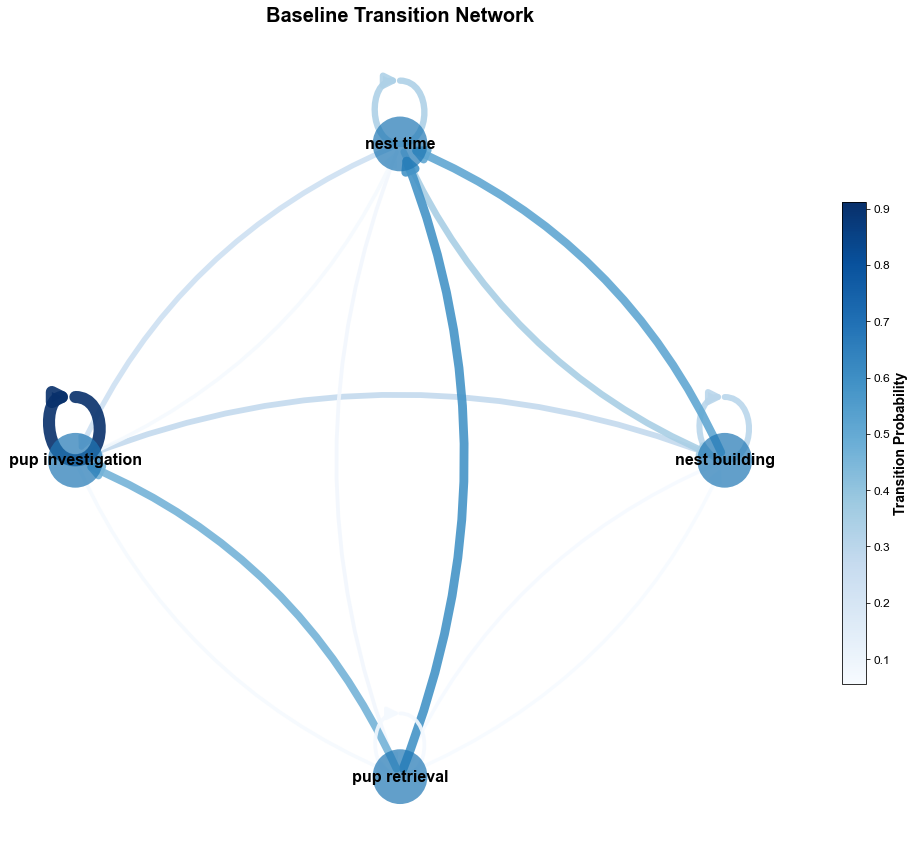

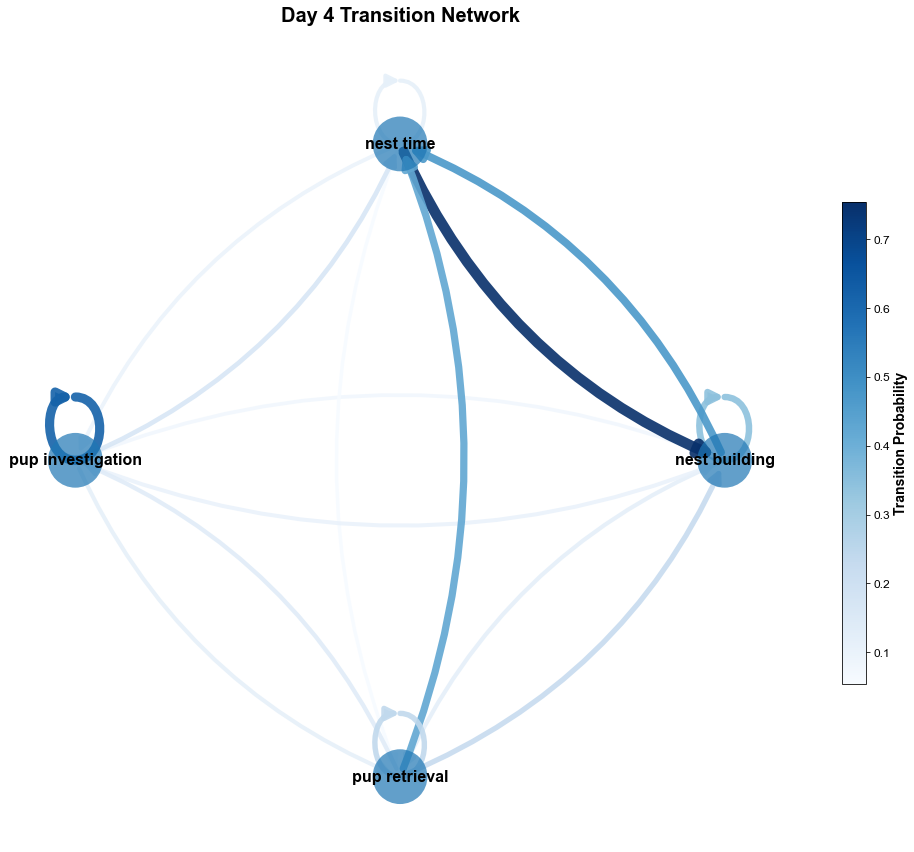

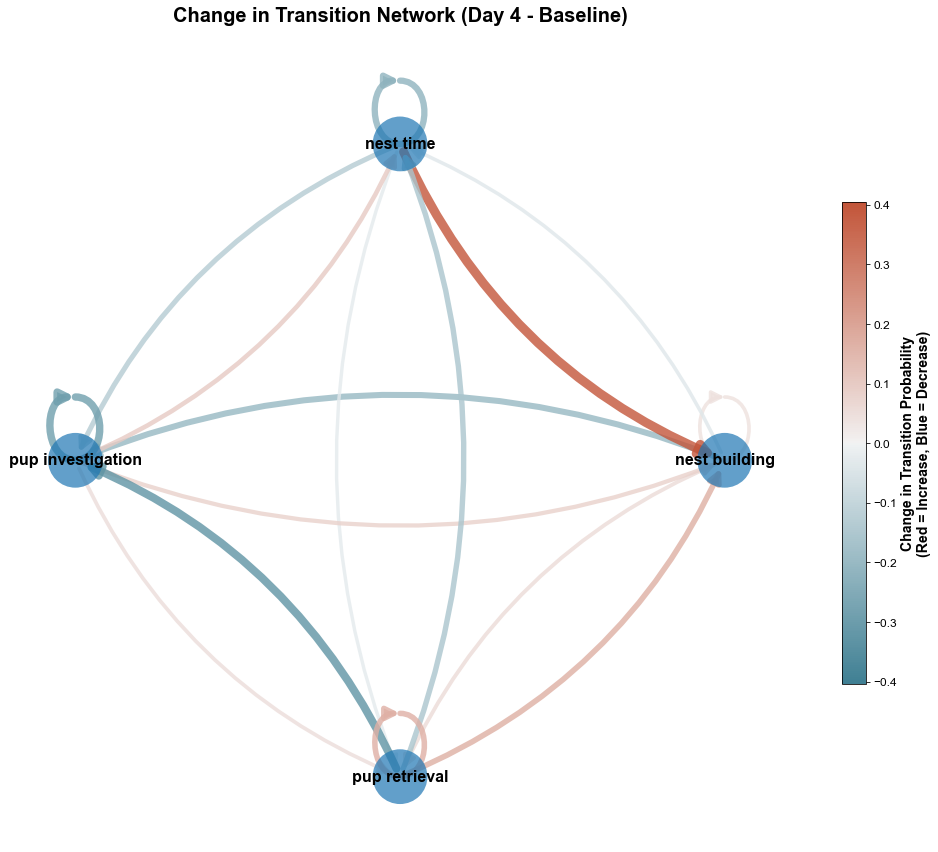

In [38]:
# PLOT 3: Transition networks for baseline and day4
# Function to create a modified transition graph with improved aesthetics
# This function will create a directed graph with better node and edge styling
# It will also include a colorbar for edge weights and improved label positioning
# it will also plot a graph showing the difference in transition probabilities
# between baseline and day4, using a diverging color palette for clarity
# and formatting for publication-ready figures. 
def create_modified_transition_graph(transition_matrix, title, is_difference=False, baseline_matrix=None):
    # Create directed graph
    G = nx.DiGraph()
    
    # Add nodes (behaviors)
    behaviors = transition_matrix.index
    for behavior in behaviors:
        G.add_node(behavior)
    
    # Add edges with weights based on transition probabilities
    for source in behaviors:
        for target in transition_matrix.columns:
            if target in ['ID', 'Time']:  # Skip non-behavior columns
                continue
            
            # Get transition probability
            prob = transition_matrix.loc[source, target]
            
            # Only add edges with probabilities above threshold for clarity
            threshold = 0.01 if is_difference else 0.05
            if abs(prob) > threshold:  # Use absolute value for difference graph
                G.add_edge(source, target, weight=prob, width=abs(prob)*5)
    
    # Create plot with publication-ready settings
    fig, ax = plt.subplots(figsize=(14, 12), facecolor='white')
    
    # Use a circular layout for consistency
    pos = nx.circular_layout(G)
    
    # For regular graphs or difference graph
    if not is_difference:
        # Draw nodes with standard blue color at 0.7 alpha, no border
        node_color = '#1f77b4'  # Standard blue
        
        nodes = nx.draw_networkx_nodes(
            G, pos,
            node_size=3000,
            node_color=node_color,
            edgecolors='none',  # Remove borders
            alpha=0.7,  # Set transparency to 0.7
            ax=ax
        )
        
        # Draw node labels without background
        labels = nx.draw_networkx_labels(
            G, pos,
            font_size=16,  # Increased font size
            font_weight='bold',
            font_color='black',
            ax=ax
        )
        
        # Get edge weights for line thickness and color intensity
        edge_weights = [G[u][v]['weight'] for u, v in G.edges()]
        
        # Safety check - if no edges, return the figure early
        if not edge_weights:
            ax.set_title(title, fontsize=20, fontweight='bold', pad=20)
            ax.set_axis_off()
            return fig
        
        # Create a blue colormap for edges (darker blue for higher probabilities)
        edge_cmap = plt.cm.Blues
        
        # Draw edges with varying color based on weight
        edges = nx.draw_networkx_edges(
            G, pos,
            width=[3 + w*10 for w in edge_weights],  # Scale for better visibility
            edge_color=edge_weights,
            edge_cmap=edge_cmap,
            edge_vmin=min(edge_weights),
            edge_vmax=max(edge_weights),
            arrowsize=25,
            arrowstyle='-|>',
            connectionstyle='arc3,rad=0.2',  # More curved edges for clarity
            alpha=0.9,
            ax=ax
        )
        
        # Add colorbar to show the probability scale
        sm = plt.cm.ScalarMappable(cmap=edge_cmap, norm=plt.Normalize(
            min(edge_weights),
            max(edge_weights)
        ))
        sm.set_array([])
        cbar = fig.colorbar(sm, ax=ax, shrink=0.6, pad=0.05)
        cbar.set_label('Transition Probability', fontsize=14, fontweight='bold')
        
    else:
        # This is the difference graph - use diverging colors but same node styling
        # Draw nodes with standard blue color at 0.7 alpha, no border
        node_color = '#1f77b4'  # Standard blue
        
        nodes = nx.draw_networkx_nodes(
            G, pos,
            node_size=3000,
            node_color=node_color,
            edgecolors='none',  # Remove borders
            alpha=0.7,  # Set transparency to 0.7
            ax=ax
        )
        
        # Draw node labels without background
        labels = nx.draw_networkx_labels(
            G, pos,
            font_size=16,  # Increased font size
            font_weight='bold',
            font_color='black',
            ax=ax
        )
        
        # Get edge weights for line thickness and color
        edge_weights = [G[u][v]['weight'] for u, v in G.edges()]
        
        # Safety check - if no edges, return the figure early
        if not edge_weights:
            ax.set_title(title, fontsize=20, fontweight='bold', pad=20)
            ax.set_axis_off()
            return fig
        
        # Create diverging colormap - same as dissimilarity matrix
        edge_cmap = sns.diverging_palette(220, 20, as_cmap=True)  # Blue to red
        
        # Find min/max for symmetric color scaling
        max_abs_weight = max([abs(w) for w in edge_weights])
        vmin, vmax = -max_abs_weight, max_abs_weight
        
        # Draw edges with color indicating direction of change
        edges = nx.draw_networkx_edges(
            G, pos,
            width=[3 + abs(w)*15 for w in edge_weights],  # Scale width by absolute value
            edge_color=edge_weights,
            edge_cmap=edge_cmap,
            edge_vmin=vmin,
            edge_vmax=vmax,
            arrowsize=25,
            arrowstyle='-|>',
            connectionstyle='arc3,rad=0.2',
            alpha=0.8,
            ax=ax
        )
        
        # Add colorbar for difference graph
        sm = plt.cm.ScalarMappable(cmap=edge_cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
        sm.set_array([])
        cbar = fig.colorbar(sm, ax=ax, shrink=0.6, pad=0.05)
        cbar.set_label('Change in Transition Probability\n(Red = Increase, Blue = Decrease)', 
                      fontsize=14, fontweight='bold')
    
    # Add title with improved formatting
    ax.set_title(title, fontsize=20, fontweight='bold', pad=20)
    
    # Clean up plot area
    ax.set_axis_off()
    
    return fig
    # Create directed graph
    G = nx.DiGraph()
    
    # Add nodes (behaviors)
    behaviors = transition_matrix.index
    for behavior in behaviors:
        G.add_node(behavior)
    
    # Add edges with weights based on transition probabilities
    for source in behaviors:
        for target in transition_matrix.columns:
            if target in ['ID', 'Time']:  # Skip non-behavior columns
                continue
            
            # Get transition probability
            prob = transition_matrix.loc[source, target]
            
            # Only add edges with probabilities above threshold for clarity
            threshold = 0.01 if is_difference else 0.05
            if abs(prob) > threshold:  # Use absolute value for difference graph
                G.add_edge(source, target, weight=prob, width=abs(prob)*5)
    
    # Create plot with publication-ready settings
    fig, ax = plt.subplots(figsize=(14, 12), facecolor='white')
    
    # Use a circular layout for consistency
    pos = nx.circular_layout(G)
    
    # For regular graphs or difference graph
    if not is_difference:
        # Draw nodes with lighter color and more transparency
        node_color = '#e6f2ff'  # Very light blue
        
        nodes = nx.draw_networkx_nodes(
            G, pos,
            node_size=3000,
            node_color=node_color,
            edgecolors='lightgray',  # Lighter border
            linewidths=1,
            alpha=0.6,  # More transparent
            ax=ax
        )
        
        # Draw node labels with improved legibility
        labels = nx.draw_networkx_labels(
            G, pos,
            font_size=16,  # Increased font size
            font_weight='bold',
            font_color='black',
            bbox=dict(facecolor='white', edgecolor='none', alpha=0.7, pad=6),  # Add white background
            ax=ax
        )
        
        # Get edge weights for line thickness and color intensity
        edge_weights = [G[u][v]['weight'] for u, v in G.edges()]
        
        # Safety check - if no edges, return the figure early
        if not edge_weights:
            ax.set_title(title, fontsize=20, fontweight='bold', pad=20)
            ax.set_axis_off()
            return fig
        
        # Create a blue colormap for edges (darker blue for higher probabilities)
        edge_cmap = plt.cm.Blues
        
        # Draw edges with varying color based on weight
        edges = nx.draw_networkx_edges(
            G, pos,
            width=[3 + w*10 for w in edge_weights],  # Scale for better visibility
            edge_color=edge_weights,
            edge_cmap=edge_cmap,
            edge_vmin=min(edge_weights),
            edge_vmax=max(edge_weights),
            arrowsize=25,
            arrowstyle='-|>',
            connectionstyle='arc3,rad=0.2',  # More curved edges for clarity
            alpha=0.9,
            ax=ax
        )
        
        # Add colorbar to show the probability scale
        sm = plt.cm.ScalarMappable(cmap=edge_cmap, norm=plt.Normalize(
            min(edge_weights),
            max(edge_weights)
        ))
        sm.set_array([])
        cbar = fig.colorbar(sm, ax=ax, shrink=0.6, pad=0.05)
        cbar.set_label('Transition Probability', fontsize=14, fontweight='bold')
        
    else:
        # This is the difference graph - use diverging colors but same node styling
        # Draw nodes with lighter color and more transparency
        node_color = '#e6f2ff'  # Very light blue
        
        nodes = nx.draw_networkx_nodes(
            G, pos,
            node_size=3000,
            node_color=node_color,
            edgecolors='lightgray',  # Lighter border
            linewidths=1,
            alpha=0.6,  # More transparent
            ax=ax
        )
        
        # Draw node labels with improved legibility
        labels = nx.draw_networkx_labels(
            G, pos,
            font_size=16,  # Increased font size
            font_weight='bold',
            font_color='black',
            bbox=dict(facecolor='white', edgecolor='none', alpha=0.7, pad=6),  # Add white background
            ax=ax
        )
        
        # Get edge weights for line thickness and color
        edge_weights = [G[u][v]['weight'] for u, v in G.edges()]
        
        # Safety check - if no edges, return the figure early
        if not edge_weights:
            ax.set_title(title, fontsize=20, fontweight='bold', pad=20)
            ax.set_axis_off()
            return fig
        
        # Create diverging colormap - same as dissimilarity matrix
        edge_cmap = sns.diverging_palette(220, 20, as_cmap=True)  # Blue to red
        
        # Find min/max for symmetric color scaling
        max_abs_weight = max([abs(w) for w in edge_weights])
        vmin, vmax = -max_abs_weight, max_abs_weight
        
        # Draw edges with color indicating direction of change
        edges = nx.draw_networkx_edges(
            G, pos,
            width=[3 + abs(w)*15 for w in edge_weights],  # Scale width by absolute value
            edge_color=edge_weights,
            edge_cmap=edge_cmap,
            edge_vmin=vmin,
            edge_vmax=vmax,
            arrowsize=25,
            arrowstyle='-|>',
            connectionstyle='arc3,rad=0.2',
            alpha=0.8,
            ax=ax
        )
        
        # Add colorbar for difference graph
        sm = plt.cm.ScalarMappable(cmap=edge_cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
        sm.set_array([])
        cbar = fig.colorbar(sm, ax=ax, shrink=0.6, pad=0.05)
        cbar.set_label('Change in Transition Probability\n(Red = Increase, Blue = Decrease)', 
                      fontsize=14, fontweight='bold')
    
    # Add title with improved formatting
    ax.set_title(title, fontsize=20, fontweight='bold', pad=20)
    
    # Clean up plot area
    ax.set_axis_off()
    
    return fig
    # Create directed graph
    G = nx.DiGraph()
    
    # Add nodes (behaviors)
    behaviors = transition_matrix.index
    for behavior in behaviors:
        G.add_node(behavior)
    
    # Add edges with weights based on transition probabilities
    for source in behaviors:
        for target in transition_matrix.columns:
            if target in ['ID', 'Time']:  # Skip non-behavior columns
                continue
            
            # Get transition probability
            prob = transition_matrix.loc[source, target]
            
            # Only add edges with probabilities above threshold for clarity
            # For difference graph, use a lower threshold
            threshold = 0.01 if is_difference else 0.05
            if abs(prob) > threshold:  # Use absolute value for difference graph
                G.add_edge(source, target, weight=prob, width=abs(prob)*5)
    
    # Create plot with publication-ready settings
    fig, ax = plt.subplots(figsize=(14, 12), facecolor='white')
    
    # Use a circular layout for consistency
    pos = nx.circular_layout(G)
    
    # For regular graphs (baseline and day4), use a blue colormap with varying intensity
    # For difference graph, use the diverging colormap
    if not is_difference:
        # Draw nodes with single color
        node_color = '#1f77b4'  # Use a standard blue color
        
        nodes = nx.draw_networkx_nodes(
            G, pos,
            node_size=3000,
            node_color=node_color,
            edgecolors='black',
            linewidths=1.5,
            alpha=0.9,
            ax=ax
        )
        
        # Draw node labels
        labels = nx.draw_networkx_labels(
            G, pos,
            font_size=14,
            font_weight='bold',
            font_color='black',
            ax=ax
        )
        
        # Get edge weights for line thickness and color intensity
        edge_weights = [G[u][v]['weight'] for u, v in G.edges()]
        
        # Safety check - if no edges, return the figure early
        if not edge_weights:
            ax.set_title(title, fontsize=20, fontweight='bold', pad=20)
            ax.set_axis_off()
            return fig
        
        # Create a blue colormap for edges (darker blue for higher probabilities)
        edge_cmap = plt.cm.Blues
        
        # Draw edges with varying color based on weight
        edges = nx.draw_networkx_edges(
            G, pos,
            width=[3 + w*10 for w in edge_weights],  # Scale for better visibility
            edge_color=edge_weights,
            edge_cmap=edge_cmap,
            edge_vmin=min(edge_weights),
            edge_vmax=max(edge_weights),
            arrowsize=25,
            arrowstyle='-|>',
            connectionstyle='arc3,rad=0.2',  # More curved edges for clarity
            alpha=0.9,
            ax=ax
        )
        
        # Add colorbar to show the probability scale
        sm = plt.cm.ScalarMappable(cmap=edge_cmap, norm=plt.Normalize(
            min(edge_weights),
            max(edge_weights)
        ))
        sm.set_array([])
        cbar = fig.colorbar(sm, ax=ax, shrink=0.6, pad=0.05)
        cbar.set_label('Transition Probability', fontsize=14, fontweight='bold')
        
    else:
        # This is the difference graph - use diverging colors
        # Draw nodes (same as regular graphs)
        node_color = '#1f77b4'  # Standard blue
        
        nodes = nx.draw_networkx_nodes(
            G, pos,
            node_size=3000,
            node_color=node_color,
            edgecolors='black',
            linewidths=1.5,
            alpha=0.9,
            ax=ax
        )
        
        # Draw node labels
        labels = nx.draw_networkx_labels(
            G, pos,
            font_size=14,
            font_weight='bold',
            font_color='black',
            ax=ax
        )
        
        # Get edge weights for line thickness and color
        edge_weights = [G[u][v]['weight'] for u, v in G.edges()]
        
        # Safety check - if no edges, return the figure early
        if not edge_weights:
            ax.set_title(title, fontsize=20, fontweight='bold', pad=20)
            ax.set_axis_off()
            return fig
        
        # Create diverging colormap - same as dissimilarity matrix
        edge_cmap = sns.diverging_palette(220, 20, as_cmap=True)  # Blue to red
        
        # Find min/max for symmetric color scaling
        max_abs_weight = max([abs(w) for w in edge_weights])
        vmin, vmax = -max_abs_weight, max_abs_weight
        
        # Draw edges with color indicating direction of change
        edges = nx.draw_networkx_edges(
            G, pos,
            width=[3 + abs(w)*15 for w in edge_weights],  # Scale width by absolute value
            edge_color=edge_weights,
            edge_cmap=edge_cmap,
            edge_vmin=vmin,
            edge_vmax=vmax,
            arrowsize=25,
            arrowstyle='-|>',
            connectionstyle='arc3,rad=0.2',
            alpha=0.8,
            ax=ax
        )
        
        # Add colorbar for difference graph
        sm = plt.cm.ScalarMappable(cmap=edge_cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
        sm.set_array([])
        cbar = fig.colorbar(sm, ax=ax, shrink=0.6, pad=0.05)
        cbar.set_label('Change in Transition Probability\n(Red = Increase, Blue = Decrease)', 
                      fontsize=14, fontweight='bold')
    
    # Add title with improved formatting
    ax.set_title(title, fontsize=20, fontweight='bold', pad=20)
    
    # Clean up plot area
    ax.set_axis_off()
    
    return fig

# Generate the three graphs (only once)
baseline_fig = create_modified_transition_graph(mean_matrices['baseline'], 'Baseline Transition Network')
baseline_fig.tight_layout()
baseline_fig.savefig('plots/baseline_transition_network.png', dpi=600, bbox_inches='tight')

day4_fig = create_modified_transition_graph(mean_matrices['day4'], 'Day 4 Transition Network')
day4_fig.tight_layout()
day4_fig.savefig('plots/day4_transition_network.png', dpi=600, bbox_inches='tight')

# Create the difference graph
difference_matrix = mean_matrices['day4'] - mean_matrices['baseline']
diff_fig = create_modified_transition_graph(difference_matrix, 'Change in Transition Network (Day 4 - Baseline)', 
                                           is_difference=True)
diff_fig.tight_layout()
diff_fig.savefig('plots/difference_transition_network.png', dpi=600, bbox_inches='tight')

plt.show()

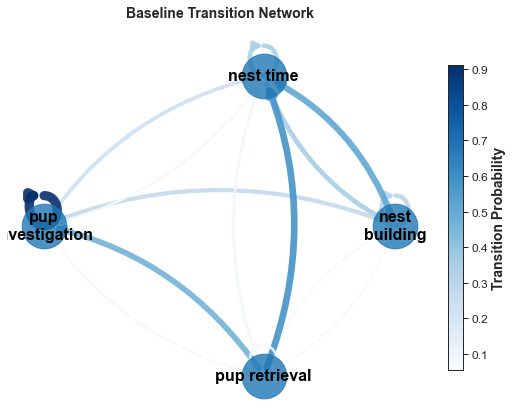

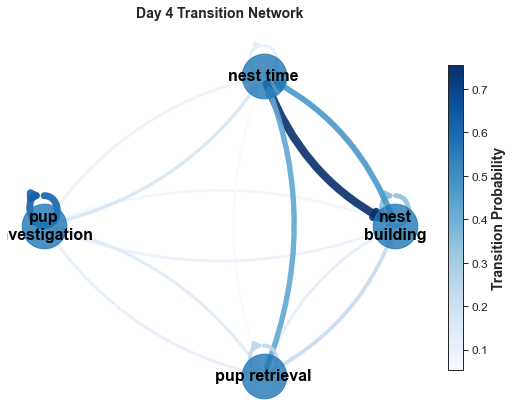

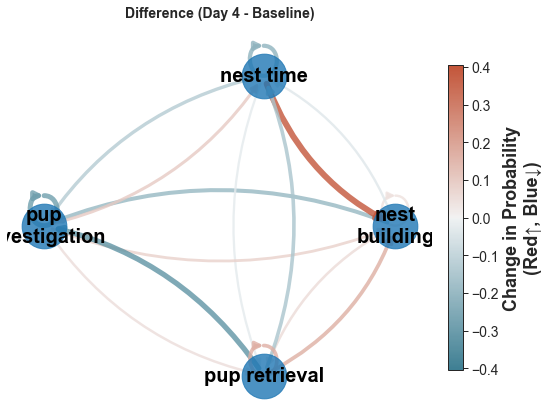

In [ ]:
# PLOT 3: Transition networks for baseline and day4 - COMPACT VERSION
def create_compact_transition_graph(transition_matrix, title, is_difference=False):
    # Create directed graph
    G = nx.DiGraph()
    
    # Add nodes (behaviors)
    behaviors = transition_matrix.index
    for behavior in behaviors:
        G.add_node(behavior)
    
    # Add edges with weights based on transition probabilities
    for source in behaviors:
        for target in transition_matrix.columns:
            if target in ['ID', 'Time']:  # Skip non-behavior columns
                continue
            
            # Get transition probability
            prob = transition_matrix.loc[source, target]
            
            # Only add edges with probabilities above threshold for clarity
            threshold = 0.01 if is_difference else 0.05
            if abs(prob) > threshold:  # Use absolute value for difference graph
                G.add_edge(source, target, weight=prob, width=abs(prob)*5)
    
    # Create plot with more compact dimensions
    fig, ax = plt.subplots(figsize=(8, 7), facecolor='white')
    plt.subplots_adjust(wspace=0.1, left=0.05, right=0.95)  # Increase space between plots and add margin
    
    # Use a circular layout for consistency
    pos = nx.circular_layout(G)
    
    # Manually adjust positions of overlapping nodes
    if 'pup investigation' in pos and 'nest building' in pos:
        # Move pup investigation outward
        angle = np.arctan2(pos['pup investigation'][1], pos['pup investigation'][0])
        pos['pup investigation'] = np.array([
            1.25 * np.cos(angle),
            1.25 * np.sin(angle)
        ])
        
        # Move nest building inward
        angle = np.arctan2(pos['nest building'][1], pos['nest building'][0])
        pos['nest building'] = np.array([
            0.75 * np.cos(angle),
            0.75 * np.sin(angle)
        ])
    
    # For regular graphs or difference graph
    if not is_difference:
        # Draw nodes with standard blue color
        node_color = '#1f77b4'  # Standard blue
        
        nodes = nx.draw_networkx_nodes(
            G, pos,
            node_size=2000,
            node_color=node_color,
            edgecolors=node_color,
            linewidths=1.0,
            alpha=0.8,
            ax=ax
        )
        
        # Create a custom label dictionary with multiline labels
        custom_labels = {}
        for node in G.nodes():
            if node == 'pup investigation':
                custom_labels[node] = 'pup\ninvestigation'
            elif node == 'nest building':
                custom_labels[node] = 'nest\nbuilding'
            else:
                custom_labels[node] = node
        
        # Draw node labels WITHOUT white backgrounds
        labels = nx.draw_networkx_labels(
            G, pos,
            labels=custom_labels,
            font_size=16,
            font_weight='bold',
            font_color='black',
            ax=ax
        )
        
        # Get edge weights for line thickness and color intensity
        edge_weights = [G[u][v]['weight'] for u, v in G.edges()]
        
        # Safety check - if no edges, return the figure early
        if not edge_weights:
            ax.set_title(title, fontsize=14, fontweight='bold', pad=10)
            ax.set_axis_off()
            return fig
        
        # Create a blue colormap for edges
        edge_cmap = plt.cm.Blues
        
        # Draw edges with varying color based on weight
        edges = nx.draw_networkx_edges(
            G, pos,
            width=[2 + w*8 for w in edge_weights],
            edge_color=edge_weights,
            edge_cmap=edge_cmap,
            edge_vmin=min(edge_weights),
            edge_vmax=max(edge_weights),
            arrowsize=15,
            arrowstyle='-|>',
            connectionstyle='arc3,rad=0.2',
            alpha=0.9,
            ax=ax
        )
        
        # Add colorbar to show the probability scale
        sm = plt.cm.ScalarMappable(cmap=edge_cmap, norm=plt.Normalize(
            min(edge_weights),
            max(edge_weights)
        ))
        sm.set_array([])
        cbar = fig.colorbar(sm, ax=ax, shrink=0.8, pad=0.03)
        cbar.set_label('Transition Probability', fontsize=14, fontweight='bold')
        cbar.ax.tick_params(labelsize=12)
        
    else:
        # This is the difference graph - use diverging colors
        node_color = '#1f77b4'  # Standard blue
        
        nodes = nx.draw_networkx_nodes(
            G, pos,
            node_size=2000,
            node_color=node_color,
            edgecolors=node_color,
            linewidths=1.0,
            alpha=0.8,
            ax=ax
        )
        
        # Create a custom label dictionary with multiline labels
        custom_labels = {}
        for node in G.nodes():
            if node == 'pup investigation':
                custom_labels[node] = 'pup\ninvestigation'
            elif node == 'nest building':
                custom_labels[node] = 'nest\nbuilding'
            else:
                custom_labels[node] = node
        
        # Draw node labels WITHOUT white backgrounds
        labels = nx.draw_networkx_labels(
            G, pos,
            labels=custom_labels,
            font_size=20,
            font_weight='bold',
            font_color='black',
            ax=ax
        )
        
        # Get edge weights for line thickness and color
        edge_weights = [G[u][v]['weight'] for u, v in G.edges()]
        
        # Safety check - if no edges, return the figure early
        if not edge_weights:
            ax.set_title(title, fontsize=18, fontweight='bold', pad=10)
            ax.set_axis_off()
            return fig
        
        # Create diverging colormap
        edge_cmap = sns.diverging_palette(220, 20, as_cmap=True)  # Blue to red
        
        # Find min/max for symmetric color scaling
        max_abs_weight = max([abs(w) for w in edge_weights])
        vmin, vmax = -max_abs_weight, max_abs_weight
        
        # Draw edges with color indicating direction of change
        edges = nx.draw_networkx_edges(
            G, pos,
            width=[2 + abs(w)*10 for w in edge_weights],
            edge_color=edge_weights,
            edge_cmap=edge_cmap,
            edge_vmin=vmin,
            edge_vmax=vmax,
            arrowsize=15,
            arrowstyle='-|>',
            connectionstyle='arc3,rad=0.2',
            alpha=0.8,
            ax=ax
        )
        
        # Add colorbar for difference graph
        sm = plt.cm.ScalarMappable(cmap=edge_cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
        sm.set_array([])
        cbar = fig.colorbar(sm, ax=ax, shrink=0.8, pad=0.03)
        cbar.set_label('Change in Probability\n(Red↑, Blue↓)', fontsize=18, fontweight='bold')
        cbar.ax.tick_params(labelsize=14)
    
    # Add title with improved formatting
    ax.set_title(title, fontsize=14, fontweight='bold', pad=10)
    
    # Clean up plot area
    ax.set_axis_off()
    
    return fig

# Generate and display the baseline graph
baseline_fig = create_compact_transition_graph(mean_matrices['baseline'], 'Baseline Transition Network')
baseline_fig.savefig('plots/compact_baseline_transition.png', dpi=300, bbox_inches='tight')
plt.show()

# Generate and display the day 4 graph
day4_fig = create_compact_transition_graph(mean_matrices['day4'], 'Day 4 Transition Network')
day4_fig.savefig('plots/compact_day4_transition.png', dpi=300, bbox_inches='tight')
plt.show()

# Generate and display the difference graph
difference_matrix = mean_matrices['day4'] - mean_matrices['baseline'] 
diff_fig = create_compact_transition_graph(difference_matrix, 'Difference (Day 4 - Baseline)', is_difference=True)
diff_fig.savefig('plots/compact_difference_transition.png', dpi=300, bbox_inches='tight')
plt.show()

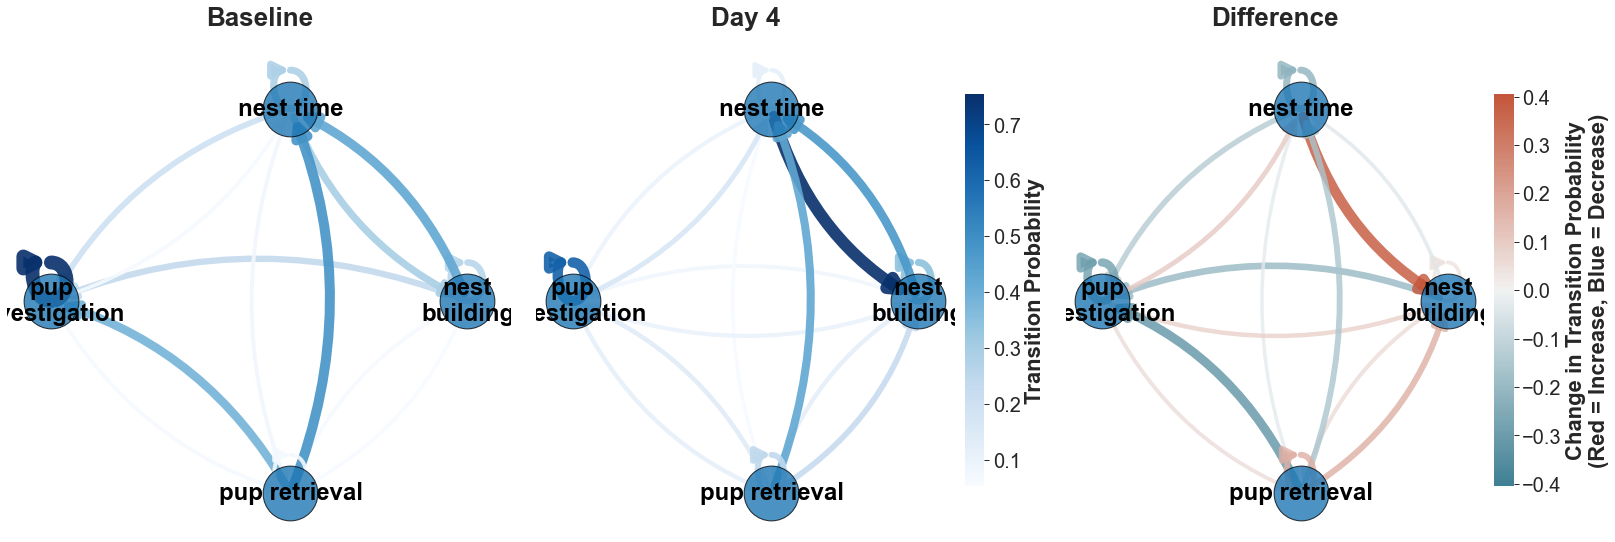

In [107]:
# PLOT 3: Transition networks for baseline and day4, side by side with difference
# Create a function to generate transition network on a given axis
def create_modified_transition_graph_on_axis(transition_matrix, title, ax, add_cbar=False, is_difference=False):
    # Create directed graph
    G = nx.DiGraph()
    
    # Add nodes (behaviors)
    behaviors = transition_matrix.index
    for behavior in behaviors:
        G.add_node(behavior)
    
    # Add edges with weights based on transition probabilities
    for source in behaviors:
        for target in transition_matrix.columns:
            if target in ['ID', 'Time']:  # Skip non-behavior columns
                continue
            
            # Get transition probability
            prob = transition_matrix.loc[source, target]
            
            # Only add edges with probabilities above threshold for clarity
            threshold = 0.01 if is_difference else 0.05
            if abs(prob) > threshold:  # Use absolute value for difference graph
                G.add_edge(source, target, weight=prob, width=abs(prob)*5)
    
    # Use a circular layout for consistency
    pos = nx.circular_layout(G)
    
    # Manually adjust positions of overlapping nodes
    # Slightly adjust the positions of pup investigation and nest building
    if 'pup investigation' in pos and 'nest building' in pos:
        # Move pup investigation slightly outward
        angle = np.arctan2(pos['pup investigation'][1], pos['pup investigation'][0])
        pos['pup investigation'] = np.array([
            1.15 * np.cos(angle),
            1.15 * np.sin(angle)
        ])
        
        # Move nest building slightly inward
        angle = np.arctan2(pos['nest building'][1], pos['nest building'][0])
        pos['nest building'] = np.array([
            0.85 * np.cos(angle),
            0.85 * np.sin(angle)
        ])
    
    # For regular graphs or difference graph
    if not is_difference:
        # Draw nodes with standard blue color at 0.7 alpha
        node_color = '#1f77b4'  # Standard blue
        
        nodes = nx.draw_networkx_nodes(
            G, pos,
            node_size=3000,  # Slightly reduced node size to avoid covering labels
            node_color=node_color,
            edgecolors='black',
            linewidths=1.0,
            alpha=0.8,
            ax=ax
        )
        
        # Create a custom label dictionary with multiline labels
        custom_labels = {}
        for node in G.nodes():
            if node == 'pup investigation':
                custom_labels[node] = 'pup\ninvestigation'
            elif node == 'nest building':
                custom_labels[node] = 'nest\nbuilding'
            else:
                custom_labels[node] = node
        
        # Draw node labels with larger font size
        labels = nx.draw_networkx_labels(
            G, pos,
            labels=custom_labels,  # Use the custom labels with line breaks
            font_size=24,  # Increased font size
            font_weight='bold',
            font_color='black',
            ax=ax
        )
        
        # Get edge weights for line thickness and color intensity
        edge_weights = [G[u][v]['weight'] for u, v in G.edges()]
        
        # Safety check - if no edges, return early
        if not edge_weights:
            ax.set_title(title, fontsize=26, fontweight='bold', pad=20)
            ax.set_axis_off()
            return
        
        # Create a blue colormap for edges (darker blue for higher probabilities)
        edge_cmap = plt.cm.Blues
        
        # Draw edges with varying color based on weight
        edges = nx.draw_networkx_edges(
            G, pos,
            width=[3 + w*12 for w in edge_weights],  # Scale for better visibility
            edge_color=edge_weights,
            edge_cmap=edge_cmap,
            edge_vmin=min(edge_weights),
            edge_vmax=max(edge_weights),
            arrowsize=30,
            arrowstyle='-|>',
            connectionstyle='arc3,rad=0.2',  # More curved edges for clarity
            alpha=0.9,
            ax=ax
        )
        
        # Add colorbar to show the probability scale (only if requested)
        if add_cbar:
            sm = plt.cm.ScalarMappable(cmap=edge_cmap, norm=plt.Normalize(
                min(edge_weights),
                max(edge_weights)
            ))
            sm.set_array([])
            cbar = plt.colorbar(sm, ax=ax, shrink=0.8, pad=0.02)  # Increased size
            cbar.outline.set_visible(False)  # Remove black contour
            cbar.set_label('Transition Probability', fontsize=22, fontweight='bold')
            cbar.ax.tick_params(labelsize=20)  # Increased tick label size
        
    else:
        # This is the difference graph - use diverging colors but same node styling
        node_color = '#1f77b4'  # Standard blue
        
        nodes = nx.draw_networkx_nodes(
            G, pos,
            node_size=3000,  # Slightly reduced node size to avoid covering labels
            node_color=node_color,
            edgecolors='black',
            linewidths=1.0,
            alpha=0.8,
            ax=ax
        )
        
        # Create a custom label dictionary with multiline labels
        custom_labels = {}
        for node in G.nodes():
            if node == 'pup investigation':
                custom_labels[node] = 'pup\ninvestigation'
            elif node == 'nest building':
                custom_labels[node] = 'nest\nbuilding'
            else:
                custom_labels[node] = node
        
        # Draw node labels with larger font size
        labels = nx.draw_networkx_labels(
            G, pos,
            labels=custom_labels,  # Use the custom labels with line breaks
            font_size=24,  # Increased font size
            font_weight='bold',
            font_color='black',
            ax=ax
        )
        
        # Get edge weights for line thickness and color
        edge_weights = [G[u][v]['weight'] for u, v in G.edges()]
        
        # Safety check - if no edges, return early
        if not edge_weights:
            ax.set_title(title, fontsize=26, fontweight='bold', pad=20)
            ax.set_axis_off()
            return
        
        # Create diverging colormap - same as dissimilarity matrix
        edge_cmap = sns.diverging_palette(220, 20, as_cmap=True)  # Blue to red
        
        # Find min/max for symmetric color scaling
        max_abs_weight = max([abs(w) for w in edge_weights])
        vmin, vmax = -max_abs_weight, max_abs_weight
        
        # Draw edges with color indicating direction of change
        edges = nx.draw_networkx_edges(
            G, pos,
            width=[3 + abs(w)*18 for w in edge_weights],  # Scale width by absolute value
            edge_color=edge_weights,
            edge_cmap=edge_cmap,
            edge_vmin=vmin,
            edge_vmax=vmax,
            arrowsize=30,
            arrowstyle='-|>',
            connectionstyle='arc3,rad=0.2',
            alpha=0.8,
            ax=ax
        )
        
        # Add colorbar for difference graph (only if requested)
        if add_cbar:
            sm = plt.cm.ScalarMappable(cmap=edge_cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
            sm.set_array([])
            cbar = plt.colorbar(sm, ax=ax, shrink=0.8, pad=0.02)  # Increased size
            cbar.outline.set_visible(False)  # Remove black contour
            cbar.set_label('Change in Transition Probability\n(Red = Increase, Blue = Decrease)', 
                         fontsize=22, fontweight='bold')
            cbar.ax.tick_params(labelsize=20)  # Increased tick label size
    
    # Add title with improved formatting
    ax.set_title(title, fontsize=26, fontweight='bold', pad=20)
    
    # Clean up plot area
    ax.set_axis_off()

# Create a single figure with 3 subplots for the networks
fig, axes = plt.subplots(1, 3, figsize=(28, 9), facecolor='white')

# Calculate difference matrix
difference_matrix = mean_matrices['day4'] - mean_matrices['baseline']

# 1. Plot baseline transition network (no colorbar)
create_modified_transition_graph_on_axis(
    mean_matrices['baseline'], 
    'Baseline', 
    axes[0], 
    add_cbar=False
)

# 2. Plot day4 transition network with colorbar on right
create_modified_transition_graph_on_axis(
    mean_matrices['day4'], 
    'Day 4', 
    axes[1], 
    add_cbar=True
)

# 3. Plot difference network with colorbar on right
create_modified_transition_graph_on_axis(
    difference_matrix, 
    'Difference', 
    axes[2], 
    add_cbar=True,
    is_difference=True
)

# Adjust spacing between subplots
plt.subplots_adjust(wspace=0.05)

# Save the combined figure
plt.savefig('plots/transition_networks_combined.png', dpi=600, bbox_inches='tight')
plt.show()

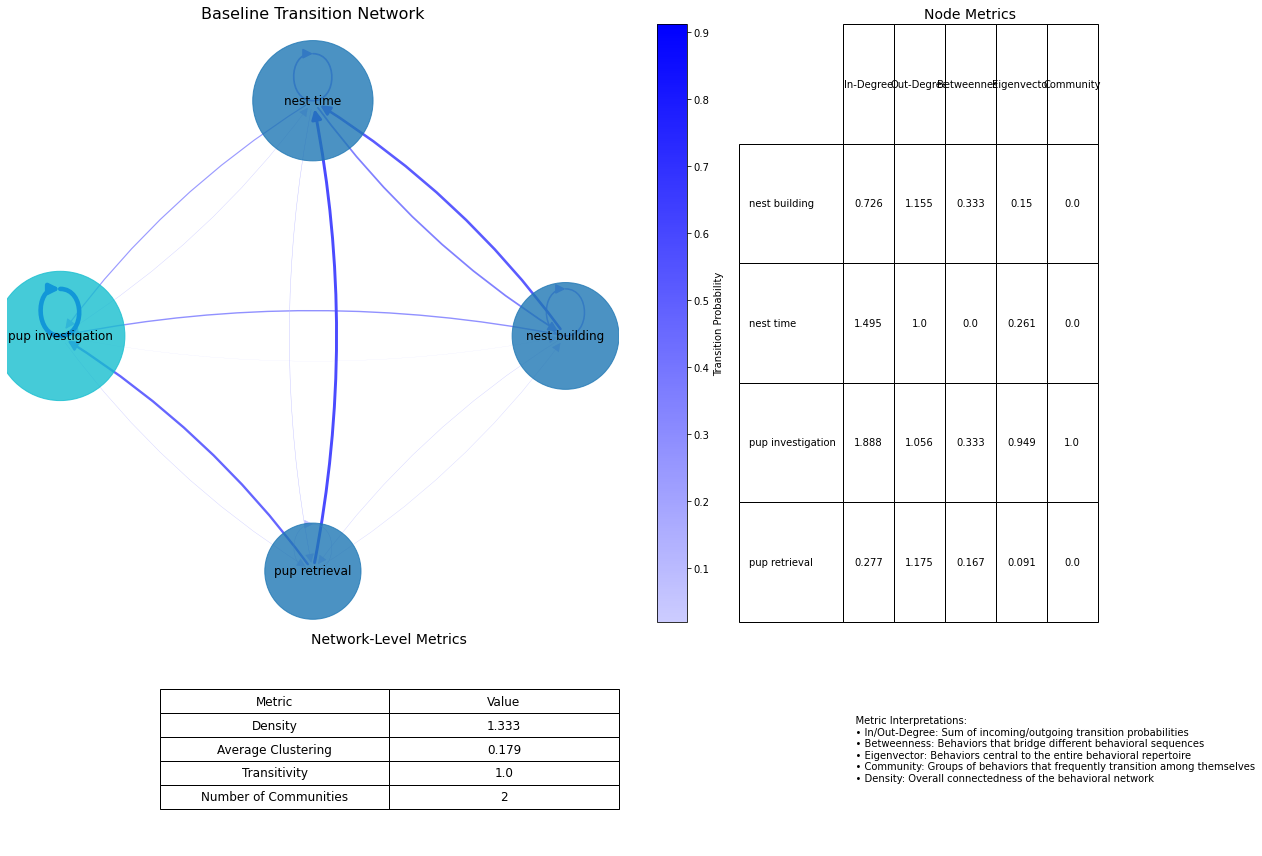

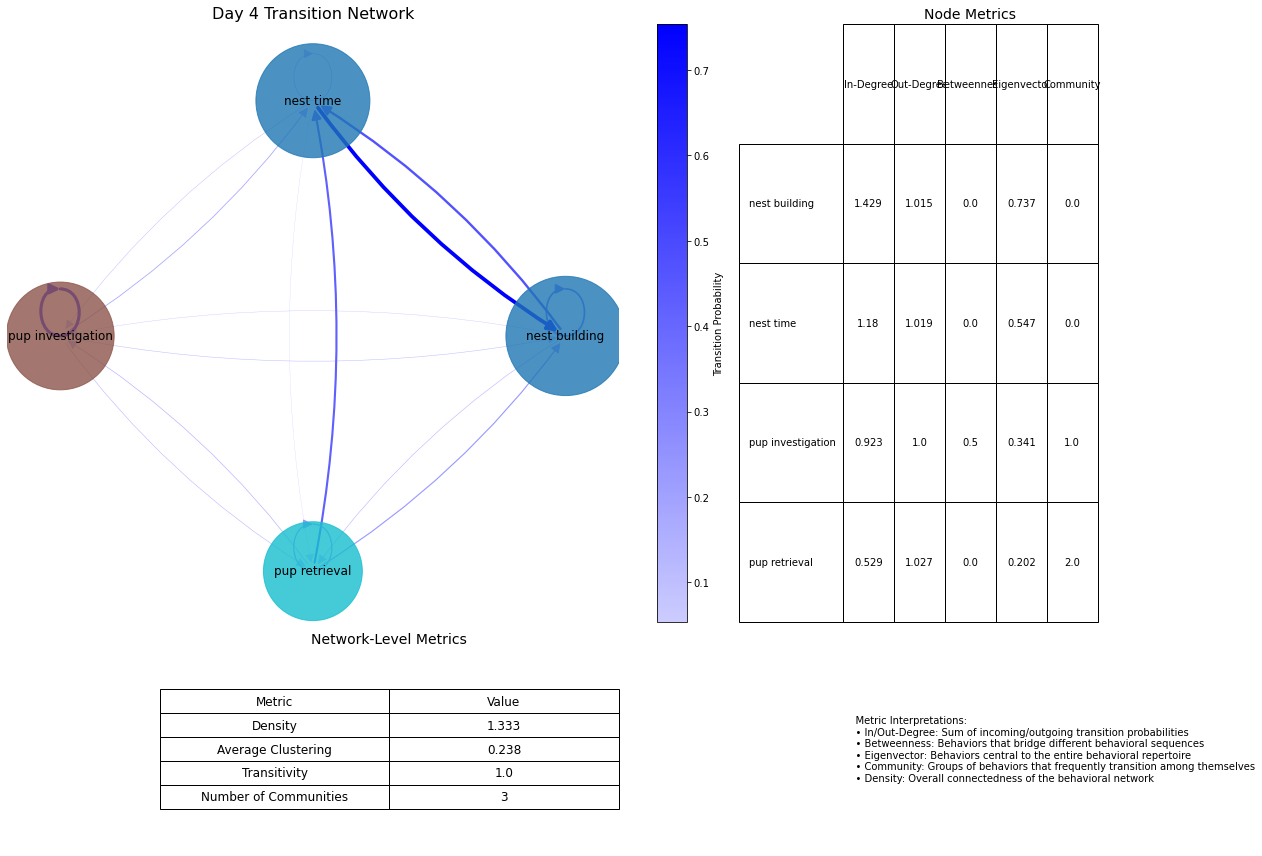

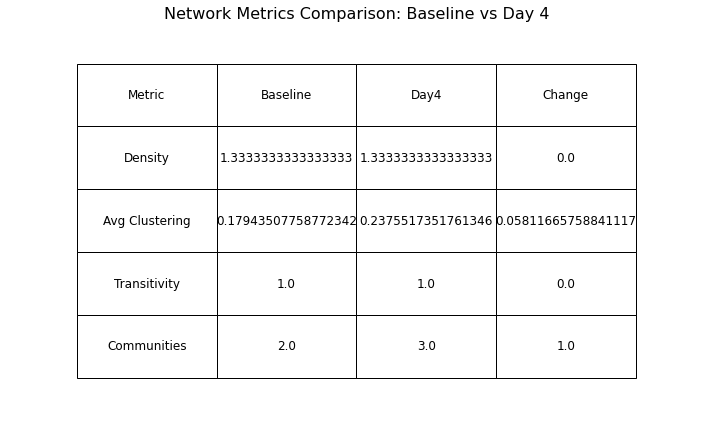

Network analysis complete. Metrics saved to plots folder.


In [ ]:
## ATTEMPT AT NETWORK GRAPH WITH METRICS - DON'T LOOK AT THIS

# import pandas as pd
# import numpy as np
# import seaborn as sns
# import matplotlib.pyplot as plt
# from glob import glob
# import networkx as nx
# from matplotlib.colors import LinearSegmentedColormap
# import matplotlib.gridspec as gridspec
# from networkx.algorithms import community

# # Enhanced function to create transition graph with metrics
# def create_transition_graph_with_metrics(transition_matrix, title):
#     # Create directed graph
#     G = nx.DiGraph()
    
#     # Add nodes (behaviors)
#     behaviors = transition_matrix.index
#     for behavior in behaviors:
#         G.add_node(behavior)
    
#     # Add edges with weights based on transition probabilities
#     for source in behaviors:
#         for target in transition_matrix.columns:
#             if target in ['ID', 'Time']:  # Skip non-behavior columns
#                 continue
            
#             # Get transition probability
#             prob = transition_matrix.loc[source, target]
            
#             # Only add edges with non-zero probability
#             if prob > 0:
#                 G.add_edge(source, target, weight=prob, width=prob*5)
    
#     # Calculate network metrics
#     metrics = {}
    
#     # Calculate node-level metrics
#     metrics['in_degree'] = dict(G.in_degree(weight='weight'))
#     metrics['out_degree'] = dict(G.out_degree(weight='weight'))
#     metrics['betweenness'] = nx.betweenness_centrality(G, weight='weight')
#     metrics['eigenvector'] = nx.eigenvector_centrality(G, weight='weight', max_iter=1000)
    
#     # Calculate network-level metrics
#     metrics['density'] = nx.density(G)
#     metrics['avg_clustering'] = nx.average_clustering(G, weight='weight')
#     metrics['transitivity'] = nx.transitivity(G)
    
#     try:
#         # Detect communities (groups of behaviors that transition frequently among themselves)
#         communities = community.greedy_modularity_communities(G, weight='weight')
#         community_dict = {}
#         for i, comm in enumerate(communities):
#             for node in comm:
#                 community_dict[node] = i
#         metrics['communities'] = community_dict
#     except:
#         metrics['communities'] = {node: 0 for node in G.nodes()}
    
#     # Create plot with subplot grid: graph + metrics tables
#     fig = plt.figure(figsize=(18, 12))
#     gs = gridspec.GridSpec(2, 2, width_ratios=[3, 1], height_ratios=[3, 1])
    
#     # Main network plot
#     ax_main = plt.subplot(gs[0, 0])
    
#     # Position nodes in a circular layout
#     pos = nx.circular_layout(G)
    
#     # Use community information for node colors if available
#     node_colors = [metrics['communities'].get(node, 0) for node in G.nodes()]
    
#     # Size nodes by their total degree centrality
#     node_sizes = [2000 + 5000 * (metrics['in_degree'][node] + metrics['out_degree'][node]) for node in G.nodes()]
    
#     # Draw nodes
#     nx.draw_networkx_nodes(G, pos, 
#                           node_size=node_sizes, 
#                           node_color=node_colors, 
#                           cmap=plt.cm.tab10, 
#                           alpha=0.8,
#                           ax=ax_main)
    
#     # Draw node labels
#     nx.draw_networkx_labels(G, pos, font_size=12, ax=ax_main)
    
#     # Get edge weights for line thickness and color intensity
#     edge_weights = [G[u][v]['weight'] for u, v in G.edges()]
    
#     # Create custom colormap for edges (from light to dark blue)
#     edge_cmap = LinearSegmentedColormap.from_list("edge_colormap", ["#CCCCFF", "#0000FF"])
    
#     # Draw edges with varying thickness and color based on weight
#     nx.draw_networkx_edges(
#         G, pos, 
#         width=[w*5 for w in edge_weights],  # Scale up for visibility
#         edge_color=edge_weights,
#         edge_cmap=edge_cmap,
#         edge_vmin=min(edge_weights) if edge_weights else 0,
#         edge_vmax=max(edge_weights) if edge_weights else 1,
#         arrowsize=20,
#         connectionstyle='arc3,rad=0.1',  # Curved edges for clearer visualization
#         ax=ax_main
#     )
    
#     # Add colorbar for edges
#     sm = plt.cm.ScalarMappable(cmap=edge_cmap, norm=plt.Normalize(
#         min(edge_weights) if edge_weights else 0, 
#         max(edge_weights) if edge_weights else 1
#     ))
#     sm.set_array([])
#     plt.colorbar(sm, ax=ax_main, label='Transition Probability')
    
#     ax_main.set_title(title, fontsize=16)
#     ax_main.axis('off')
    
#     # Create table with node-level metrics
#     ax_node_metrics = plt.subplot(gs[0, 1])
#     ax_node_metrics.axis('off')
    
#     # Create DataFrame of node metrics for easy display
#     node_metrics_df = pd.DataFrame({
#         'In-Degree': [round(metrics['in_degree'][node], 3) for node in behaviors],
#         'Out-Degree': [round(metrics['out_degree'][node], 3) for node in behaviors],
#         'Betweenness': [round(metrics['betweenness'][node], 3) for node in behaviors],
#         'Eigenvector': [round(metrics['eigenvector'][node], 3) for node in behaviors],
#         'Community': [metrics['communities'][node] for node in behaviors]
#     }, index=behaviors)
    
#     # Plot node metrics table
#     table_node = ax_node_metrics.table(
#         cellText=node_metrics_df.values.round(3),
#         rowLabels=node_metrics_df.index,
#         colLabels=node_metrics_df.columns,
#         cellLoc='center',
#         loc='center',
#         bbox=[0, 0, 1, 1]
#     )
#     table_node.auto_set_font_size(False)
#     table_node.set_fontsize(10)
#     table_node.scale(1, 1.5)
#     ax_node_metrics.set_title('Node Metrics', fontsize=14)
    
#     # Create table with network-level metrics
#     ax_network_metrics = plt.subplot(gs[1, 0])
#     ax_network_metrics.axis('off')
    
#     # Plot network metrics
#     network_metrics = [
#         ['Density', round(metrics['density'], 3)],
#         ['Average Clustering', round(metrics['avg_clustering'], 3)],
#         ['Transitivity', round(metrics['transitivity'], 3)],
#         ['Number of Communities', len(set(metrics['communities'].values()))],
#     ]
    
#     network_table = ax_network_metrics.table(
#         cellText=network_metrics,
#         colLabels=['Metric', 'Value'],
#         cellLoc='center',
#         loc='center',
#         bbox=[0.2, 0.2, 0.6, 0.6]
#     )
#     network_table.auto_set_font_size(False)
#     network_table.set_fontsize(12)
#     network_table.scale(1, 1.5)
#     ax_network_metrics.set_title('Network-Level Metrics', fontsize=14)
    
#     # Graph interpretation hints
#     ax_interpretation = plt.subplot(gs[1, 1])
#     ax_interpretation.axis('off')
#     interpretation_text = """
#     Metric Interpretations:
#     • In/Out-Degree: Sum of incoming/outgoing transition probabilities
#     • Betweenness: Behaviors that bridge different behavioral sequences
#     • Eigenvector: Behaviors central to the entire behavioral repertoire
#     • Community: Groups of behaviors that frequently transition among themselves
#     • Density: Overall connectedness of the behavioral network
#     """
#     ax_interpretation.text(0, 0.5, interpretation_text, va='center', fontsize=10)
    
#     plt.tight_layout()
    
#     # Return both the figure and metrics dictionary
#     return fig, metrics

# # Calculate and visualize network metrics for baseline and day4
# baseline_fig, baseline_metrics = create_transition_graph_with_metrics(
#     mean_matrices['baseline'], 'Baseline Transition Network'
# )
# baseline_fig.savefig('plots/baseline_transition_network_with_metrics.png', dpi=300, bbox_inches='tight')

# day4_fig, day4_metrics = create_transition_graph_with_metrics(
#     mean_matrices['day4'], 'Day 4 Transition Network'
# )
# day4_fig.savefig('plots/day4_transition_network_with_metrics.png', dpi=300, bbox_inches='tight')

# # Compare metrics between baseline and day4
# metrics_comparison = pd.DataFrame({
#     'Metric': ['Density', 'Avg Clustering', 'Transitivity', 'Communities'],
#     'Baseline': [
#         baseline_metrics['density'], 
#         baseline_metrics['avg_clustering'], 
#         baseline_metrics['transitivity'],
#         len(set(baseline_metrics['communities'].values()))
#     ],
#     'Day4': [
#         day4_metrics['density'], 
#         day4_metrics['avg_clustering'], 
#         day4_metrics['transitivity'],
#         len(set(day4_metrics['communities'].values()))
#     ],
#     'Change': [
#         day4_metrics['density'] - baseline_metrics['density'],
#         day4_metrics['avg_clustering'] - baseline_metrics['avg_clustering'],
#         day4_metrics['transitivity'] - baseline_metrics['transitivity'],
#         len(set(day4_metrics['communities'].values())) - len(set(baseline_metrics['communities'].values()))
#     ]
# })

# # Create a figure for the comparison
# plt.figure(figsize=(10, 6))
# ax = plt.subplot(111)
# ax.axis('off')
# comparison_table = ax.table(
#     cellText=metrics_comparison.values,
#     colLabels=metrics_comparison.columns,
#     loc='center',
#     cellLoc='center',
#     bbox=[0.1, 0.1, 0.8, 0.8]
# )
# comparison_table.auto_set_font_size(False)
# comparison_table.set_fontsize(12)
# comparison_table.scale(1, 1.5)
# plt.title('Network Metrics Comparison: Baseline vs Day 4', fontsize=16)
# plt.tight_layout()
# plt.savefig('plots/network_metrics_comparison.png', dpi=300, bbox_inches='tight')
# plt.show()

# # Save metrics to CSV for further analysis
# node_metrics_baseline = pd.DataFrame({
#     'Behavior': list(baseline_metrics['in_degree'].keys()),
#     'In_Degree_Baseline': list(baseline_metrics['in_degree'].values()),
#     'Out_Degree_Baseline': list(baseline_metrics['out_degree'].values()),
#     'Betweenness_Baseline': list(baseline_metrics['betweenness'].values()),
#     'Eigenvector_Baseline': list(baseline_metrics['eigenvector'].values()),
#     'Community_Baseline': [baseline_metrics['communities'][node] for node in baseline_metrics['in_degree'].keys()]
# })

# node_metrics_day4 = pd.DataFrame({
#     'Behavior': list(day4_metrics['in_degree'].keys()),
#     'In_Degree_Day4': list(day4_metrics['in_degree'].values()),
#     'Out_Degree_Day4': list(day4_metrics['out_degree'].values()),
#     'Betweenness_Day4': list(day4_metrics['betweenness'].values()),
#     'Eigenvector_Day4': list(day4_metrics['eigenvector'].values()),
#     'Community_Day4': [day4_metrics['communities'][node] for node in day4_metrics['in_degree'].keys()]
# })

# # Merge the two dataframes on behavior
# node_metrics_comparison = pd.merge(node_metrics_baseline, node_metrics_day4, on='Behavior')
# node_metrics_comparison.to_csv('plots/node_metrics_comparison.csv', index=False)

# print("Network analysis complete. Metrics saved to plots folder.")

In [ ]:
# WILCOXON SIGNED-RANK TEST WITH FDR CORRECTION 

# Calculate the difference matrix (already done in your existing code)
difference_matrix = mean_matrices['day4'] - mean_matrices['baseline']

# Create DataFrames to store statistical results
wilcoxon_results = pd.DataFrame(index=difference_matrix.index, columns=difference_matrix.columns)
p_values = pd.DataFrame(index=difference_matrix.index, columns=difference_matrix.columns)
significant_changes = pd.DataFrame(index=difference_matrix.index, columns=difference_matrix.columns)

# Loop through all transition pairs
all_p_values = []
all_p_value_positions = []  # Store (state1, state2) for each p-value

for state1 in difference_matrix.index:
    for state2 in difference_matrix.columns:
        # Skip if column is ID or Time
        if state2 in ['ID', 'Time']:
            continue
            
        # Extract transition probabilities for this pair at baseline and day4
        # Need to match by mouse ID to ensure proper pairing
        baseline_day4_paired = []
        
        for mouse_id in IDs:
            try:
                # Get baseline value for this mouse and transition
                baseline_val = transition_matrices[
                    (transition_matrices.Time == 'baseline') & 
                    (transition_matrices.ID == mouse_id) & 
                    (transition_matrices.index.get_level_values('state1') == state1)
                ][state2].values
                
                # Get day4 value for this mouse and transition
                day4_val = transition_matrices[
                    (transition_matrices.Time == 'day4') & 
                    (transition_matrices.ID == mouse_id) & 
                    (transition_matrices.index.get_level_values('state1') == state1)
                ][state2].values
                
                # If both exist, add the pair to our list
                if len(baseline_val) > 0 and len(day4_val) > 0:
                    baseline_day4_paired.append((baseline_val[0], day4_val[0]))
            except:
                continue
        
        # Skip pairs with insufficient data
        if len(baseline_day4_paired) < 3:
            p_values.loc[state1, state2] = np.nan
            continue
            
        # Unzip the pairs into separate baseline and day4 lists
        baseline_values, day4_values = zip(*baseline_day4_paired)
        
        # Perform Wilcoxon signed-rank test
        try:
            stat, p = wilcoxon(baseline_values, day4_values)
            p_values.loc[state1, state2] = p
            all_p_values.append(p)
            all_p_value_positions.append((state1, state2))
        except Exception as e:
            print(f"Error with {state1}->{state2}: {e}")
            p_values.loc[state1, state2] = np.nan

# Apply FDR correction to all p-values
if all_p_values:  # Make sure we have p-values to correct
    reject, p_corrected, _, _ = multipletests(
        np.array(all_p_values), 
        alpha=0.05, 
        method='fdr_bh'  # Benjamini-Hochberg procedure
    )
    
    # Print original and corrected p-values for comparison
    print("Original vs FDR-corrected p-values:")
    print("{:<15} {:<15} {:<15} {:<15} {:<10}".format("From", "To", "Original p", "Corrected p", "Significant"))
    print("-" * 65)
    for i, (state1, state2) in enumerate(all_p_value_positions):
        original_p = all_p_values[i]
        corrected_p = p_corrected[i]
        sig = "Yes" if reject[i] else "No"
        print("{:<15} {:<15} {:<15.4f} {:<15.4f} {:<10}".format(state1, state2, original_p, corrected_p, sig))
    
    # Create a DataFrame with original and corrected p-values
    p_value_comparison = pd.DataFrame({
        'state1': [p[0] for p in all_p_value_positions],
        'state2': [p[1] for p in all_p_value_positions],
        'original_p': all_p_values,
        'corrected_p': p_corrected,
        'significant': reject
    })
    print("\nP-value comparison DataFrame:")
    print(p_value_comparison)
    
    # Update significance based on corrected p-values
    for i, (state1, state2) in enumerate(all_p_value_positions):
        if reject[i]:  # If null hypothesis is rejected (significant after correction)
            if p_corrected[i] < 0.01:
                significant_changes.loc[state1, state2] = '**'
            else:
                significant_changes.loc[state1, state2] = '*'
        else:
            significant_changes.loc[state1, state2] = ''

Original vs FDR-corrected p-values:
From            To              Original p      Corrected p     Significant
-----------------------------------------------------------------
nest building   nest building   0.4631          0.5000          No        
nest building   nest time       0.4688          0.5000          No        
nest building   pup investigation 0.0796          0.1274          No        
nest building   pup retrieval   0.0679          0.1274          No        
nest time       nest building   0.0625          0.1274          No        
nest time       nest time       0.0679          0.1274          No        
nest time       pup investigation 0.1088          0.1583          No        
nest time       pup retrieval   0.2850          0.3508          No        
pup investigation nest building   0.0425          0.1274          No        
pup investigation nest time       0.0180          0.1274          No        
pup investigation pup investigation 0.0180          0.1274      

/Users/irenesalgarella/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/morestats.py:3141: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/Users/irenesalgarella/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/morestats.py:3155: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


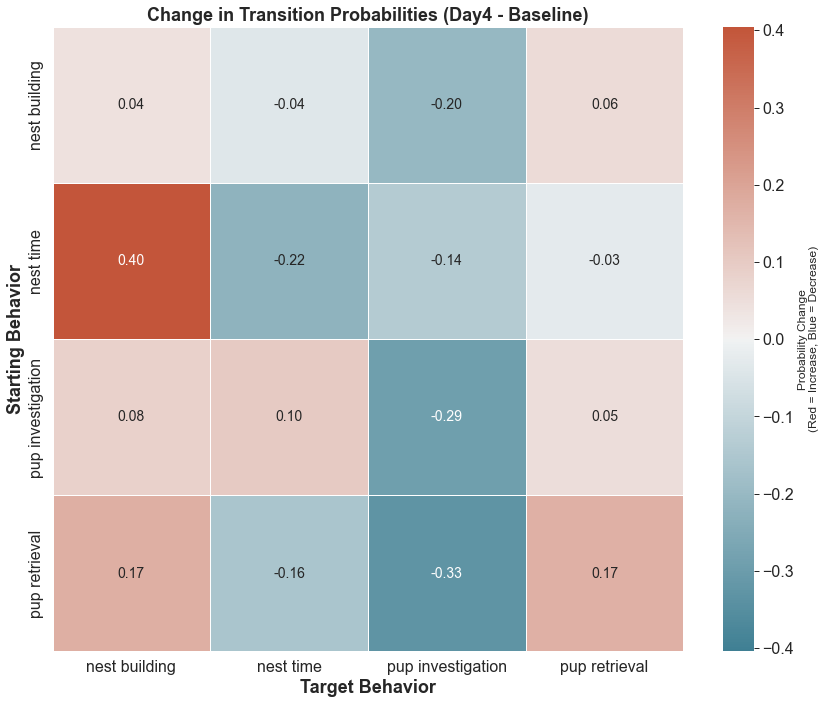

In [97]:
# visualise a dissimilarity matrix as a heatmap 

plt.rcParams.update({
    'font.family': 'sans-serif',
    'font.sans-serif': ['Arial'],
    'font.size': 14,  # Increased base font size
    'axes.labelsize': 18,  # Increased from 14
    'axes.titlesize': 18,  # Increased from 16
    'xtick.labelsize': 16,  # Increased from 12
    'ytick.labelsize': 16,  # Increased from 12
    'legend.fontsize': 14,
    'figure.titlesize': 18
})

# Create a diverging colormap for the heatmap
cmap = sns.diverging_palette(220, 20, as_cmap=True)  # Blue to red

# Set vmin and vmax to be symmetric around 0 for balanced colormap
max_abs_diff = max(abs(difference_matrix.values.min()), abs(difference_matrix.values.max()))
vmin, vmax = -max_abs_diff, max_abs_diff

# Create the heatmap with significance markers
plt.figure(figsize=(12, 10))

# Create the heatmap
ax = sns.heatmap(difference_matrix, 
                 cmap=cmap,
                 vmin=vmin, vmax=vmax, 
                 center=0,
                 annot=True, 
                 fmt=".2f",
                 linewidths=0.5)

# Add significance markers
for i, state1 in enumerate(difference_matrix.index):
    for j, state2 in enumerate(difference_matrix.columns):
        if state2 not in ['ID', 'Time'] and significant_changes.loc[state1, state2] in ['*', '**']:
            ax.text(j + 0.5, i + 0.85, significant_changes.loc[state1, state2],
                   ha='center', va='center', color='black', fontweight='bold')

plt.title('Change in Transition Probabilities (Day4 - Baseline)', fontweight='bold', fontsize=18)
plt.xlabel('Target Behavior', fontweight='bold', fontsize=18)
plt.ylabel('Starting Behavior', fontweight='bold', fontsize=18)

# Add a descriptive colorbar label
cbar = plt.gcf().axes[-1]
cbar.set_ylabel('Probability Change\n(Red = Increase, Blue = Decrease)', fontsize=12)

# # Add a note about significance markers
# plt.figtext(0.5, 0.01, '* p<0.05, ** p<0.01 (Wilcoxon signed-rank test, FDR-corrected)', 
#             ha='center', fontsize=10)

plt.tight_layout()
plt.savefig('plots/transition_probability_differences_wilcoxon_fdr.png', dpi=300, bbox_inches='tight')
plt.show()




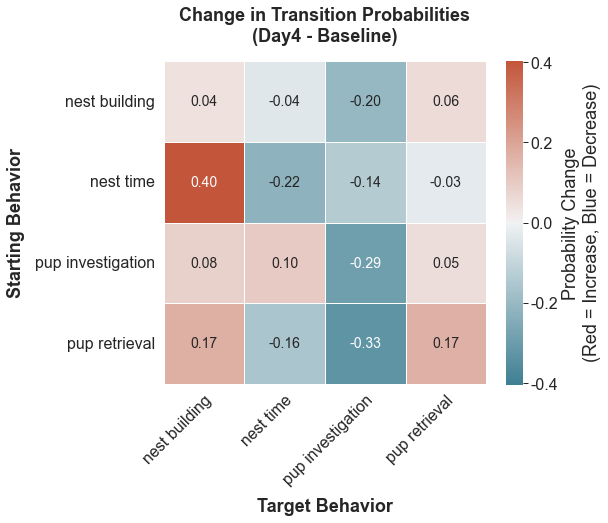

In [101]:
# Visualize dissimilarity matrix with size matching baseline/day4 heatmaps
plt.rcParams.update({
    'font.family': 'sans-serif',
    'font.sans-serif': ['Arial'],
    'font.size': 14,
    'axes.labelsize': 18,
    'axes.titlesize': 18,
    'xtick.labelsize': 16,
    'ytick.labelsize': 16,
    'legend.fontsize': 14,
    'figure.titlesize': 18
})

# Create a diverging colormap for the heatmap (keep as requested)
cmap = sns.diverging_palette(220, 20, as_cmap=True)  # Blue to red

# Set vmin and vmax to be symmetric around 0 for balanced colormap
max_abs_diff = max(abs(difference_matrix.values.min()), abs(difference_matrix.values.max()))
vmin, vmax = -max_abs_diff, max_abs_diff

# Define tick values that will show as decimal numbers
tick_values = np.round(np.linspace(-max_abs_diff, max_abs_diff, 5), 1)

# Create figure with size matching the individual panels but with added top margin for title
fig = plt.figure(figsize=(7, 7.5))

# Create the heatmap with updated formatting to match other plots
# Adjust the positioning to leave room for the title
ax = plt.subplot(111)
hm = sns.heatmap(
    difference_matrix, 
    cmap=cmap,  # Keep the diverging colormap
    vmin=vmin, 
    vmax=vmax, 
    center=0,  # Important for diverging colormap
    annot=True, 
    fmt=".2f",
    linewidths=0.5,
    cbar_kws={
        'label': 'Probability Change\n(Red = Increase, Blue = Decrease)',
        'shrink': 0.8,
        'aspect': 20,
        'ticks': tick_values  # Use the calculated tick values
    },
    square=True,  # Make cells square like other heatmaps
    annot_kws={'size': 14},  # Match annotation size
    ax=ax
)

# Add significance markers
for i, state1 in enumerate(difference_matrix.index):
    for j, state2 in enumerate(difference_matrix.columns):
        if state2 not in ['ID', 'Time'] and significant_changes.loc[state1, state2] in ['*', '**']:
            # Position slightly higher in the cell for better visibility
            plt.text(j + 0.5, i + 0.85, significant_changes.loc[state1, state2],
                   ha='center', va='center', color='black', fontweight='bold')

# Improve title and axis labels to match other heatmaps
ax.set_title('Change in Transition Probabilities\n(Day4 - Baseline)', fontweight='bold', fontsize=18, pad=20)
ax.set_xlabel('Target Behavior', fontweight='bold', fontsize=18, labelpad=10)
ax.set_ylabel('Starting Behavior', fontweight='bold', fontsize=18, labelpad=10)

# Format colorbar with larger label size and decimal formatting
cbar = hm.collections[0].colorbar
if cbar is not None:
    cbar.ax.tick_params(labelsize=16)  # Increase tick label size
    cbar.set_ticks(tick_values)
    cbar.set_ticklabels([f"{x:.1f}" for x in tick_values])  # Format as decimals
    cbar.ax.set_ylabel('Probability Change\n(Red = Increase, Blue = Decrease)', fontsize=18)

# Adjust tick label formatting with increased font size
plt.setp(plt.gca().get_xticklabels(), rotation=45, ha='right', rotation_mode='anchor', fontsize=16)
plt.setp(plt.gca().get_yticklabels(), rotation=0, fontsize=16)

# Adjust subplot parameters to give more space at the top for the title
plt.subplots_adjust(top=0.9, bottom=0.15, left=0.15, right=0.95)

plt.savefig('plots/transition_probability_dissimilarity_matrix.png', dpi=600, bbox_inches='tight')
plt.show()

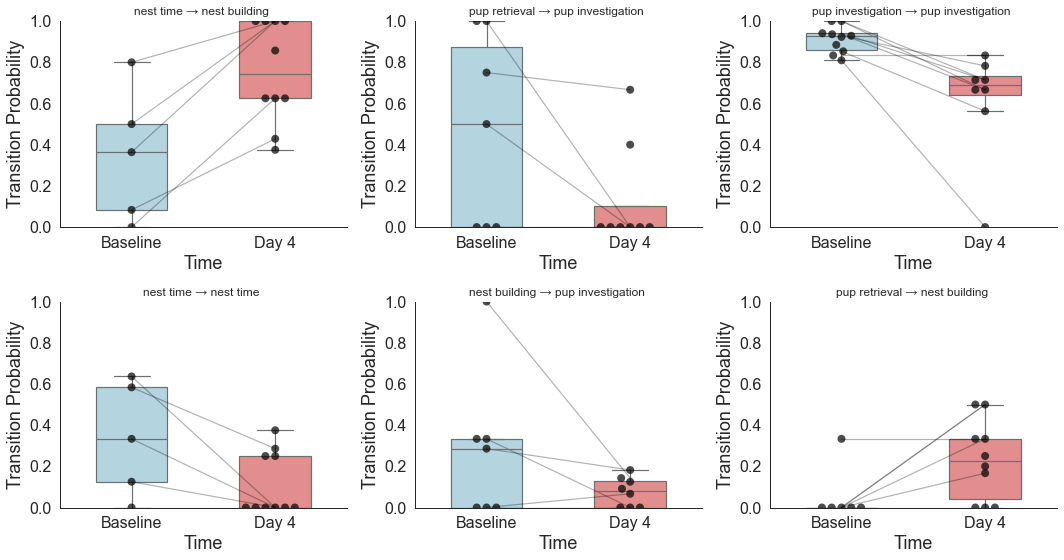

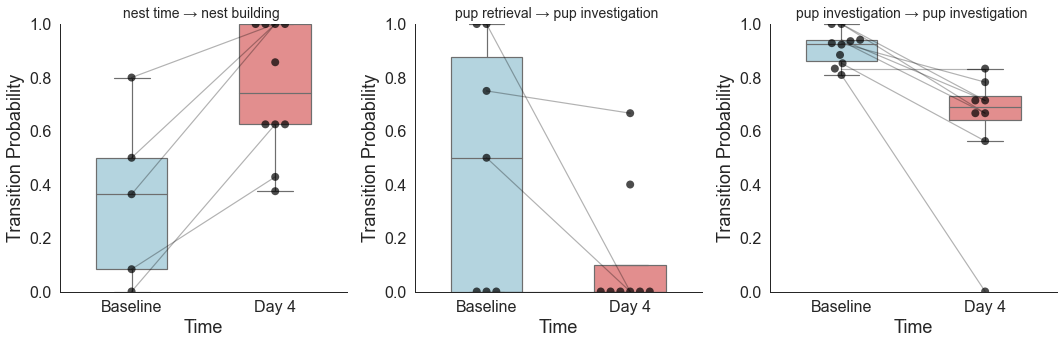

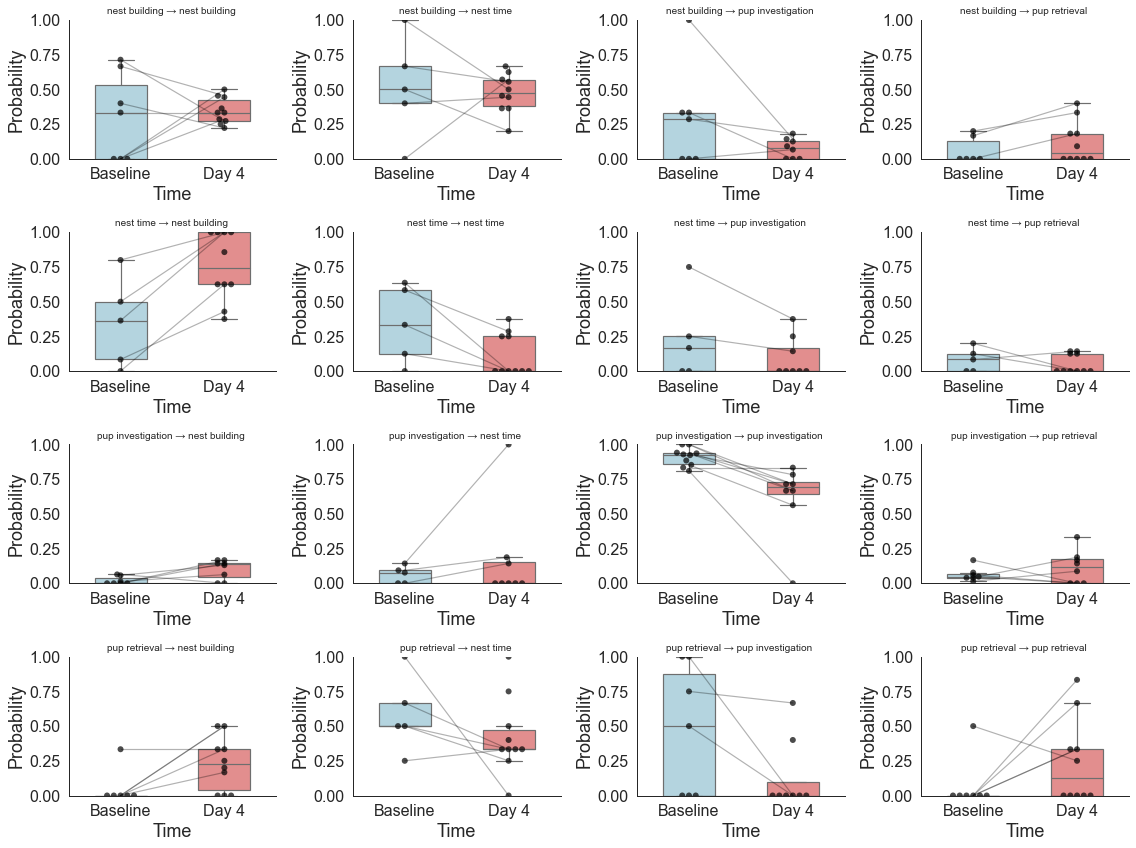

In [ ]:
# BOXPLOT AND SWARMPLOT FOR INDIVIDUAL MOUSE TRANSITION PROBABILITIES
# Create visualization of individual mouse transition probabilities
# First, prepare a dataframe that's suitable for plotting
transition_data = []

# Find significant transitions based on FDR-corrected p-values
if 'p_value_comparison' in locals():
    significant_transitions = p_value_comparison[p_value_comparison['significant'] == True]
    
    # Limit to top significant transitions if there are too many
    if len(significant_transitions) > 6:
        significant_transitions = significant_transitions.sort_values('corrected_p').iloc[:6]
    
    # If no significant transitions, just use the ones with the largest absolute difference
    if len(significant_transitions) == 0:
        # Find transitions with largest absolute differences
        diff_df = pd.DataFrame()
        for state1 in difference_matrix.index:
            for state2 in difference_matrix.columns:
                if state2 not in ['ID', 'Time']:
                    diff_df = pd.concat([diff_df, pd.DataFrame({
                        'state1': [state1],
                        'state2': [state2],
                        'diff': [abs(difference_matrix.loc[state1, state2])]
                    })])
        
        significant_transitions = diff_df.sort_values('diff', ascending=False).iloc[:6]
else:
    # If no statistical analysis was done, use transitions with largest differences
    diff_df = pd.DataFrame()
    for state1 in difference_matrix.index:
        for state2 in difference_matrix.columns:
            if state2 not in ['ID', 'Time']:
                diff_df = pd.concat([diff_df, pd.DataFrame({
                    'state1': [state1],
                    'state2': [state2],
                    'diff': [abs(difference_matrix.loc[state1, state2])]
                })])
    
    significant_transitions = diff_df.sort_values('diff', ascending=False).iloc[:6]

# Collect data for all selected transitions
for _, row in significant_transitions.iterrows():
    state1 = row['state1']
    state2 = row['state2']
    
    # Extract transition probabilities for each mouse
    for mouse_id in IDs:
        try:
            # Get baseline value
            baseline_val = transition_matrices[
                (transition_matrices.Time == 'baseline') & 
                (transition_matrices.ID == mouse_id) & 
                (transition_matrices.index.get_level_values('state1') == state1)
            ][state2].values
            
            if len(baseline_val) > 0:
                transition_data.append({
                    'ID': mouse_id,
                    'Time': 'Baseline',
                    'From': state1,
                    'To': state2,
                    'Probability': baseline_val[0],
                    'Transition': f"{state1} → {state2}"
                })
            
            # Get day4 value
            day4_val = transition_matrices[
                (transition_matrices.Time == 'day4') & 
                (transition_matrices.ID == mouse_id) & 
                (transition_matrices.index.get_level_values('state1') == state1)
            ][state2].values
            
            if len(day4_val) > 0:
                transition_data.append({
                    'ID': mouse_id,
                    'Time': 'Day 4',
                    'From': state1,
                    'To': state2,
                    'Probability': day4_val[0],
                    'Transition': f"{state1} → {state2}"
                })
                
        except Exception as e:
            print(f"Error extracting data for {mouse_id}, {state1}->{state2}: {e}")


# Create dataframe from collected data
transition_df = pd.DataFrame(transition_data)

# Create a multi-panel figure for the boxplots
unique_transitions = transition_df['Transition'].unique()
n_transitions = len(unique_transitions)

# Calculate grid dimensions (aim for roughly square layout)
import math
n_cols = min(3, n_transitions)
n_rows = math.ceil(n_transitions / n_cols)

plt.figure(figsize=(n_cols*5, n_rows*4))

# Create a subplot for each transition
for i, transition in enumerate(unique_transitions):
    plt.subplot(n_rows, n_cols, i+1)
    
    # Filter data for this transition
    trans_data = transition_df[transition_df['Transition'] == transition]
    
    # Create boxplot with swarmplot overlay
    sns.boxplot(x='Time', y='Probability', data=trans_data, width=0.5, 
                palette=['lightblue', 'lightcoral'], showfliers=False)
    
    sns.swarmplot(x='Time', y='Probability', data=trans_data, 
                 size=8, color='black', alpha=0.7)
    
    # Add connecting lines between paired observations (same mouse at different timepoints)
    for mouse_id in trans_data['ID'].unique():
        mouse_data = trans_data[trans_data['ID'] == mouse_id]
        if len(mouse_data) == 2:  # Only if we have both baseline and day4
            x_vals = [0, 1]  # x positions for Baseline and Day4
            y_vals = mouse_data.sort_values('Time')['Probability'].values
            plt.plot(x_vals, y_vals, 'k-', alpha=0.3)
    
    # Add title and format
    state1, state2 = transition.split(' → ')
    
    # Add significance marker if available
    sig_marker = ''
    if 'p_value_comparison' in locals():
        sig_row = p_value_comparison[(p_value_comparison['state1'] == state1) & 
                                    (p_value_comparison['state2'] == state2)]
        if len(sig_row) > 0 and sig_row['significant'].values[0]:
            p_val = sig_row['corrected_p'].values[0]
            if p_val < 0.01:
                sig_marker = '**'
            else:
                sig_marker = '*'
    
    plt.title(f"{transition} {sig_marker}", fontsize=12)
    plt.ylabel('Transition Probability')
    plt.ylim(0, 1)
    sns.despine()

plt.tight_layout()
plt.savefig('plots/transition_probabilities_by_mouse.png', dpi=300, bbox_inches='tight')
plt.show()

# Create a summary figure with larger individual plots for the top 3 significant transitions
if len(unique_transitions) >= 3:
    plt.figure(figsize=(15, 5))
    
    for i in range(3):
        plt.subplot(1, 3, i+1)
        transition = unique_transitions[i]
        
        # Filter data for this transition
        trans_data = transition_df[transition_df['Transition'] == transition]
        
        # Create boxplot with swarmplot overlay
        sns.boxplot(x='Time', y='Probability', data=trans_data, width=0.5, 
                    palette=['lightblue', 'lightcoral'], showfliers=False)
        
        sns.swarmplot(x='Time', y='Probability', data=trans_data, 
                     size=8, color='black', alpha=0.7)
        
        # Add connecting lines between paired observations
        for mouse_id in trans_data['ID'].unique():
            mouse_data = trans_data[trans_data['ID'] == mouse_id]
            if len(mouse_data) == 2:
                x_vals = [0, 1]
                y_vals = mouse_data.sort_values('Time')['Probability'].values
                plt.plot(x_vals, y_vals, 'k-', alpha=0.3)
        
        # Add title and format
        state1, state2 = transition.split(' → ')
        
        # Add significance marker if available
        sig_marker = ''
        if 'p_value_comparison' in locals():
            sig_row = p_value_comparison[(p_value_comparison['state1'] == state1) & 
                                        (p_value_comparison['state2'] == state2)]
            if len(sig_row) > 0 and sig_row['significant'].values[0]:
                p_val = sig_row['corrected_p'].values[0]
                if p_val < 0.01:
                    sig_marker = '**'
                else:
                    sig_marker = '*'
        
        plt.title(f"{transition} {sig_marker}", fontsize=14)
        plt.ylabel('Transition Probability')
        plt.ylim(0, 1)
        sns.despine()

    plt.tight_layout()
    plt.savefig('plots/top_transition_probabilities_by_mouse.png', dpi=300, bbox_inches='tight')
    plt.show()

# After creating the first two plots, add this code to create a plot for ALL transitions

# Collect data for ALL transitions, not just significant ones
all_transition_data = []

# Get all possible transitions
all_state1 = difference_matrix.index
all_state2 = [col for col in difference_matrix.columns if col not in ['ID', 'Time']]

# Collect data for every possible transition
for state1 in all_state1:
    for state2 in all_state2:
        # Extract transition probabilities for each mouse
        for mouse_id in IDs:
            try:
                # Get baseline value
                baseline_val = transition_matrices[
                    (transition_matrices.Time == 'baseline') & 
                    (transition_matrices.ID == mouse_id) & 
                    (transition_matrices.index.get_level_values('state1') == state1)
                ][state2].values
                
                if len(baseline_val) > 0:
                    all_transition_data.append({
                        'ID': mouse_id,
                        'Time': 'Baseline',
                        'From': state1,
                        'To': state2,
                        'Probability': baseline_val[0],
                        'Transition': f"{state1} → {state2}"
                    })
                
                # Get day4 value
                day4_val = transition_matrices[
                    (transition_matrices.Time == 'day4') & 
                    (transition_matrices.ID == mouse_id) & 
                    (transition_matrices.index.get_level_values('state1') == state1)
                ][state2].values
                
                if len(day4_val) > 0:
                    all_transition_data.append({
                        'ID': mouse_id,
                        'Time': 'Day 4',
                        'From': state1,
                        'To': state2,
                        'Probability': day4_val[0],
                        'Transition': f"{state1} → {state2}"
                    })
                    
            except Exception as e:
                # Silently continue if there's an error
                continue

# now plot all remaining transitions
# Create dataframe from collected data
all_transitions_df = pd.DataFrame(all_transition_data)

# Get unique transitions
all_unique_transitions = all_transitions_df['Transition'].unique()
n_all_transitions = len(all_unique_transitions)

# Create a multi-panel figure for all transitions
# Calculate grid dimensions (aim for roughly square layout)
n_cols = min(4, n_all_transitions)  # Use 4 columns max to fit more transitions
n_rows = math.ceil(n_all_transitions / n_cols)

plt.figure(figsize=(n_cols*4, n_rows*3))  # Slightly smaller subplots to fit more

# Create a subplot for each transition
for i, transition in enumerate(all_unique_transitions):
    plt.subplot(n_rows, n_cols, i+1)
    
    # Filter data for this transition
    trans_data = all_transitions_df[all_transitions_df['Transition'] == transition]
    
    # Only plot if we have data
    if len(trans_data) > 0:
        # Create boxplot with swarmplot overlay
        sns.boxplot(x='Time', y='Probability', data=trans_data, width=0.5, 
                    palette=['lightblue', 'lightcoral'], showfliers=False)
        
        sns.swarmplot(x='Time', y='Probability', data=trans_data, 
                     size=6, color='black', alpha=0.7)  # Smaller points to reduce overlap
        
        # Add connecting lines between paired observations
        for mouse_id in trans_data['ID'].unique():
            mouse_data = trans_data[trans_data['ID'] == mouse_id]
            if len(mouse_data) == 2:  # Only if we have both baseline and day4
                x_vals = [0, 1]  # x positions for Baseline and Day4
                y_vals = mouse_data.sort_values('Time')['Probability'].values
                plt.plot(x_vals, y_vals, 'k-', alpha=0.3)
    
    # Add title and format
    state1, state2 = transition.split(' → ')
    
    # Add significance marker if available
    sig_marker = ''
    if 'p_value_comparison' in locals():
        sig_row = p_value_comparison[(p_value_comparison['state1'] == state1) & 
                                    (p_value_comparison['state2'] == state2)]
        if len(sig_row) > 0 and sig_row['significant'].values[0]:
            p_val = sig_row['corrected_p'].values[0]
            if p_val < 0.01:
                sig_marker = '**'
            else:
                sig_marker = '*'
    
    plt.title(f"{transition} {sig_marker}", fontsize=10)  # Smaller font size
    plt.ylabel('Probability')
    plt.ylim(0, 1)
    sns.despine()

plt.tight_layout()
plt.savefig('plots/all_transition_probabilities_by_mouse.png', dpi=300, bbox_inches='tight')
plt.show()

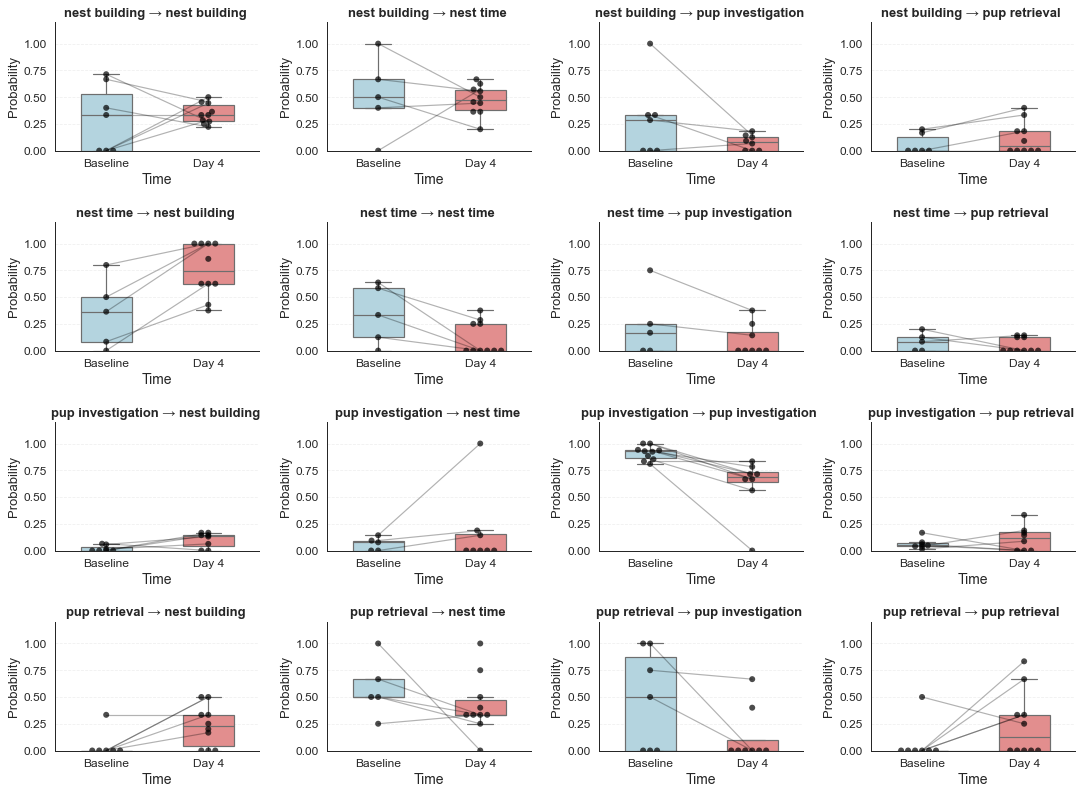

In [121]:
# Create a multi-panel figure for all transitions with improved styling
# Use a slightly smaller base figure size but maintain readability
plt.figure(figsize=(n_cols*3.8, n_rows*2.8))

# Set publication-quality styling
plt.rcParams.update({
    'font.family': 'sans-serif',
    'font.sans-serif': ['Arial'],
    'font.size': 11,
    'axes.labelsize': 14,
    'axes.titlesize': 14,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'legend.fontsize': 12
})

# Create a subplot for each transition
for i, transition in enumerate(all_unique_transitions):
    ax = plt.subplot(n_rows, n_cols, i+1)
    
    # Filter data for this transition
    trans_data = all_transitions_df[all_transitions_df['Transition'] == transition]
    
    # Only plot if we have data
    if len(trans_data) > 0:
        # Create boxplot with swarmplot overlay
        sns.boxplot(x='Time', y='Probability', data=trans_data, width=0.5, 
                    palette=['lightblue', 'lightcoral'], showfliers=False)
        
        sns.swarmplot(x='Time', y='Probability', data=trans_data, 
                     size=6, color='black', alpha=0.7)
        
        # Add connecting lines between paired observations
        for mouse_id in trans_data['ID'].unique():
            mouse_data = trans_data[trans_data['ID'] == mouse_id]
            if len(mouse_data) == 2:  # Only if we have both baseline and day4
                x_vals = [0, 1]
                y_vals = mouse_data.sort_values('Time')['Probability'].values
                plt.plot(x_vals, y_vals, 'k-', alpha=0.3)
    
    # Add title and format
    state1, state2 = transition.split(' → ')
    
    # Add significance marker if available
    sig_marker = ''
    if 'p_value_comparison' in locals():
        sig_row = p_value_comparison[(p_value_comparison['state1'] == state1) & 
                                    (p_value_comparison['state2'] == state2)]
        if len(sig_row) > 0 and sig_row['significant'].values[0]:
            p_val = sig_row['corrected_p'].values[0]
            if p_val < 0.01:
                sig_marker = '**'
            else:
                sig_marker = '*'
    
    plt.title(f"{transition} {sig_marker}", fontsize=13, fontweight='bold')
    plt.ylabel('Probability', fontsize=13)
    
    # Increase y-axis limit to prevent cutoff (adjust to 1.2 for 20% headroom)
    plt.ylim(0, 1.2)
    
    # Clean up plot appearance
    sns.despine()
    ax.tick_params(axis='both', which='major', labelsize=12)
    
    # Add light grid lines for better readability
    ax.grid(True, axis='y', alpha=0.3, linestyle='--')

# Improve overall spacing and layout
plt.tight_layout(pad=1.2, h_pad=1.8, w_pad=1.8)

# Save the figure with high resolution
plt.savefig('plots/all_transition_probabilities_by_mouse.png', dpi=600, bbox_inches='tight')
plt.show()

In [ ]:
def create_grouped_transition_plots(transition_differences):
    # Sort all transitions by absolute difference
    sorted_transitions = sorted(
        transition_differences.items(), 
        key=lambda x: x[1]['abs_diff'], 
        reverse=True
    )
    
    # Create a single figure with all transitions, organized by difference
    n_transitions = len(sorted_transitions)
    n_cols = 4  # Four columns to fit more transitions per row
    n_rows = math.ceil(n_transitions / n_cols)
    
    plt.figure(figsize=(n_cols*3.8, n_rows*2.8))
    
    # Set publication-quality styling
    plt.rcParams.update({
        'font.family': 'sans-serif',
        'font.sans-serif': ['Arial'],
        'font.size': 11,
        'axes.labelsize': 14,
        'axes.titlesize': 14,
        'xtick.labelsize': 12,
        'ytick.labelsize': 12,
        'legend.fontsize': 12
    })
    
    # Create color gradient based on difference magnitude
    max_diff = max([data['abs_diff'] for _, data in sorted_transitions])
    
    # Plot each transition in order of difference magnitude
    for i, (transition, data) in enumerate(sorted_transitions):
        ax = plt.subplot(n_rows, n_cols, i+1)
        
        # Filter data for this transition
        trans_data = all_transitions_df[all_transitions_df['Transition'] == transition]
        
        # Set background color intensity based on difference magnitude
        # Higher differences will have more intense background colors
        bg_intensity = min(1.0, data['abs_diff'] / max_diff)
        if data['direction'] == 'increase':
            # Red for increases - lighter shade for boxplot fill
            bg_color = (1.0, 0.9 - 0.4*bg_intensity, 0.9 - 0.4*bg_intensity, 0.2)
            box_palette = ['lightblue', f'rgb({255}, {int(220-100*bg_intensity)}, {int(220-100*bg_intensity)})']
        else:
            # Blue for decreases - lighter shade for boxplot fill
            bg_color = (0.9 - 0.4*bg_intensity, 0.9 - 0.4*bg_intensity, 1.0, 0.2)
            box_palette = [f'rgb({int(220-100*bg_intensity)}, {int(220-100*bg_intensity)}, {255})', 'lightcoral']
        
        # Add subtle background color to emphasize magnitude
        ax.axhspan(0, 1.2, facecolor=bg_color, alpha=0.15)
        
        # Only plot if we have data
        if len(trans_data) > 0:
            # Create boxplot with swarmplot overlay
            sns.boxplot(x='Time', y='Probability', data=trans_data, width=0.5, 
                        palette=box_palette, showfliers=False)
            
            sns.swarmplot(x='Time', y='Probability', data=trans_data, 
                         size=6, color='black', alpha=0.7)
            
            # Add connecting lines between paired observations
            for mouse_id in trans_data['ID'].unique():
                mouse_data = trans_data[trans_data['ID'] == mouse_id]
                if len(mouse_data) == 2:  # Only if we have both baseline and day4
                    x_vals = [0, 1]
                    y_vals = mouse_data.sort_values('Time')['Probability'].values
                    plt.plot(x_vals, y_vals, 'k-', alpha=0.3)
        
        # Add title and format
        state1, state2 = transition.split(' → ')
        
        # Add significance marker if available
        sig_marker = ''
        if 'p_value_comparison' in locals():
            sig_row = p_value_comparison[(p_value_comparison['state1'] == state1) & 
                                        (p_value_comparison['state2'] == state2)]
            if len(sig_row) > 0 and sig_row['significant'].values[0]:
                p_val = sig_row['corrected_p'].values[0]
                if p_val < 0.01:
                    sig_marker = '**'
                else:
                    sig_marker = '*'
        
        # Include difference magnitude in title - format depends on direction
        diff_str = f"Δ{data['abs_diff']:.2f}"
        if data['direction'] == 'increase':
            diff_str = f"↑ {diff_str}"
        else:
            diff_str = f"↓ {diff_str}"
            
        plt.title(f"{transition} [{diff_str}] {sig_marker}", fontsize=13, fontweight='bold')
        plt.ylabel('Probability', fontsize=13)
        
        # Increase y-axis limit to prevent cutoff
        plt.ylim(0, 1.2)
        
        # Clean up plot appearance
        sns.despine()
        ax.tick_params(axis='both', which='major', labelsize=12)
        ax.grid(True, axis='y', alpha=0.3, linestyle='--')
    
    # Add a color bar legend to show difference magnitude
    sm = plt.cm.ScalarMappable(cmap=plt.cm.coolwarm, 
                              norm=plt.Normalize(vmin=-max_diff, vmax=max_diff))
    sm.set_array([])
    
    # Add an empty subplot for the colorbar
    cbar_ax = plt.subplot(n_rows, n_cols, n_rows*n_cols)
    cbar = plt.colorbar(sm, cax=cbar_ax)
    cbar_ax.set_title('Difference Magnitude\n(red=increase, blue=decrease)', fontsize=12)
    cbar_ax.axis('off')  # Hide the empty plot
    
    plt.suptitle('Transition Probabilities Ordered by Magnitude of Difference', fontsize=16, y=0.98)
    plt.tight_layout(rect=[0, 0, 1, 0.96], pad=1.2, h_pad=1.8, w_pad=1.8)
    plt.savefig('plots/transition_probabilities_by_difference.png', dpi=600, bbox_inches='tight')
    plt.show()

# Call the function with the existing transition_differences dictionary
create_grouped_transition_plots(transition_differences)

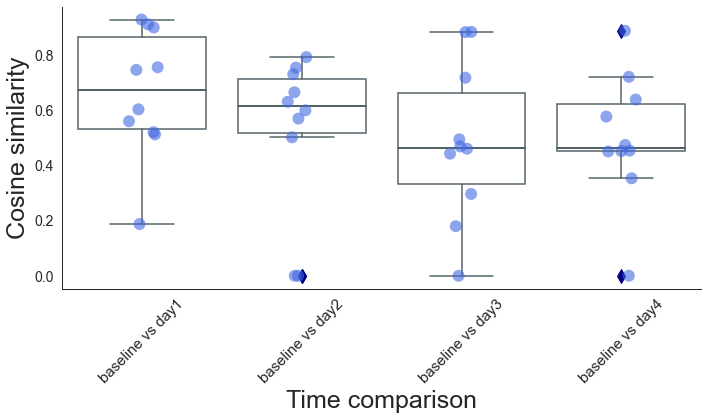

In [86]:
## COSINE SIMILARITY
## Calculate the cosine similarity between the transition matrices at baseline and all timepoints
# Create a copy of the transition matrix
transition_df = transition_matrices.copy()
transition_df.reset_index(inplace=True)

# Flatten the transition matrix
transition_matrices_stack = transition_df.melt(
    id_vars=['ID', 'Time', 'state1'], 
    value_vars=['pup retrieval', 'nest building', 'nest time', 'pup investigation'], 
    var_name='state2', 
    value_name='transition_probability'
)

# Create column with the combination of the two states
transition_matrices_stack['behaviour_combo'] = transition_matrices_stack.state1 + '_' + transition_matrices_stack.state2

# Define all timepoints to compare with baseline
comparison_times = ['day1', 'day2', 'day3', 'day4']

# Get all unique behavior combinations across all timepoints
all_combinations = transition_matrices_stack['behaviour_combo'].unique().tolist()

# Fill NaN values with 0
transition_matrices_stack['transition_probability'] = transition_matrices_stack['transition_probability'].fillna(0)

# Calculate the cosine similarity between baseline and all other timepoints
cosine_list = []
for ID in transition_matrices_stack.ID.unique():
    # Get baseline data for this mouse
    baseline_df = transition_matrices_stack[(transition_matrices_stack.ID == ID) & 
                                           (transition_matrices_stack.Time == "baseline")]
    
    # Skip if baseline data is missing for this mouse
    if len(baseline_df) == 0:
        print(f"Missing baseline data for ID {ID}")
        continue
    
    for time in comparison_times:
        # Get data for this timepoint
        time_df = transition_matrices_stack[(transition_matrices_stack.ID == ID) & 
                                           (transition_matrices_stack.Time == time)]
        
        # Skip if this timepoint is missing for this mouse
        if len(time_df) == 0:
            print(f"Missing {time} data for ID {ID}")
            continue
        
        # Get behavior combinations present in each timepoint
        baseline_combinations = baseline_df.behaviour_combo.unique()
        time_combinations = time_df.behaviour_combo.unique()
        
        # Identify missing combinations that need to be added
        baseline_missing = [combo for combo in all_combinations if combo not in baseline_combinations]
        time_missing = [combo for combo in all_combinations if combo not in time_combinations]
        
        # Add missing combinations to baseline with transition_probability = 0
        if len(baseline_missing) > 0:
            for combo in baseline_missing:
                state1, state2 = combo.split('_')
                add_df = pd.DataFrame({
                    'ID': ID, 
                    'Time': 'baseline', 
                    'state1': state1, 
                    'state2': state2, 
                    'transition_probability': 0, 
                    'behaviour_combo': combo
                }, index=[0])
                baseline_df = pd.concat([baseline_df, add_df])
        
        # Add missing combinations to time with transition_probability = 0
        if len(time_missing) > 0:
            for combo in time_missing:
                state1, state2 = combo.split('_')
                add_df = pd.DataFrame({
                    'ID': ID, 
                    'Time': time, 
                    'state1': state1, 
                    'state2': state2, 
                    'transition_probability': 0, 
                    'behaviour_combo': combo
                }, index=[0])
                time_df = pd.concat([time_df, add_df])
        
        # Ensure vectors match by explicitly indexing and sorting
        baseline_vector = baseline_df.set_index('behaviour_combo').sort_index()['transition_probability'].values
        time_vector = time_df.set_index('behaviour_combo').sort_index()['transition_probability'].values
        
        try:
            # Calculate cosine similarity
            cosine = cosine_similarity(baseline_vector.reshape(1, -1), time_vector.reshape(1, -1))
            cosine_list.append(pd.DataFrame({
                'ID': ID, 
                'Time': f'baseline vs {time}', 
                'cosine_similarity': cosine[0][0]
            }, index=[0]))
        except Exception as e:
            print(f"Error calculating cosine similarity for ID {ID} at {time}: {e}")
            print(f"Baseline vector shape: {baseline_vector.shape}")
            print(f"Time vector shape: {time_vector.shape}")
    
# Combine all results
cosine_df = pd.concat(cosine_list)

# Set the time column as categorical for proper ordering in plots
all_time_comparisons = [f'baseline vs {time}' for time in comparison_times]
cosine_df['Time'] = pd.Categorical(cosine_df['Time'], categories=all_time_comparisons, ordered=True)

plt.rcParams.update({
    'font.family': 'sans-serif',
    'font.sans-serif': ['Arial'],
    'font.size': 12,
    'axes.labelsize': 14,
    'axes.titlesize': 16,
    'xtick.labelsize': 14,
    'ytick.labelsize': 14,
    'legend.fontsize': 12,
    'figure.titlesize': 18
})

# # Plot the cosine similarities
# plt.figure(figsize=(10, 6))
# sns.boxplot(x='Time', y='cosine_similarity', data=cosine_df, color='white', showfliers=True, linewidth=1.5)
# sns.stripplot(x='Time', y='cosine_similarity', data=cosine_df, color='royalblue', size=8, jitter=True, alpha=0.7)
# sns.despine()
# plt.xticks(rotation=45)
# plt.title('Cosine similarity between baseline and subsequent timepoints', fontsize=18)
# plt.xlabel('Time comparison', fontsize=16)
# plt.ylabel('Cosine similarity', fontsize=16)
# plt.tight_layout()

# # Save plot to generated dataset folder 
# plt.savefig('plots/cosine_similarities.png', dpi=500, bbox_inches='tight')
# plt.show()

# Plot the cosine similarities
plt.figure(figsize=(10, 6))

# Modified boxplot with darker lines and navy outliers
sns.boxplot(
    x='Time', 
    y='cosine_similarity', 
    data=cosine_df, 
    color='white', 
    showfliers=True, 
    linewidth=1.5,
    boxprops={'edgecolor': '#536267'},
    whiskerprops={'color': '#536267', 'linewidth': 1.5},
    medianprops={'color': '#536267', 'linewidth': 2},
    capprops={'color': '#536267', 'linewidth': 1.5},
    flierprops={'markerfacecolor': 'navy', 'markeredgecolor': 'navy', 'markersize': 10}
)

# Add individual data points
sns.stripplot(x='Time', y='cosine_similarity', data=cosine_df, color='royalblue', size=12, jitter=True, alpha=0.6)

sns.despine()
plt.xticks(rotation=45, fontsize = 15)
# plt.title('Cosine similarity between baseline and subsequent timepoints', fontsize=18)
plt.xlabel('Time comparison', fontsize=25)
plt.ylabel('Cosine similarity', fontsize= 25)
plt.tight_layout()

# Save plot to generated dataset folder 
plt.savefig('plots/cosine_similarities.png', dpi=300, bbox_inches='tight')
plt.show()

In [84]:
cosine_df

,ID,Time,cosine_similarity
0,BRAC7159.2d,baseline vs day1,0.754254
0,BRAC7159.2d,baseline vs day2,0.663547
0,BRAC7159.2d,baseline vs day3,0.881371
0,BRAC7159.2d,baseline vs day4,0.637382
0,BRAC7172.1e,baseline vs day1,0.744699
0,BRAC7172.1e,baseline vs day2,0.752687
0,BRAC7172.1e,baseline vs day3,0.441602
0,BRAC7172.1e,baseline vs day4,0.473122
0,BRAC7172.1g,baseline vs day1,0.601970
0,BRAC7172.1g,baseline vs day2,0.629358


/var/folders/4g/5slcnh6x71lgn2r91zbk1pwr0000gn/T/ipykernel_86677/3288938158.py:87: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar = plt.colorbar(sm, ax=ax, orientation='horizontal', pad=0.15, shrink=0.8)


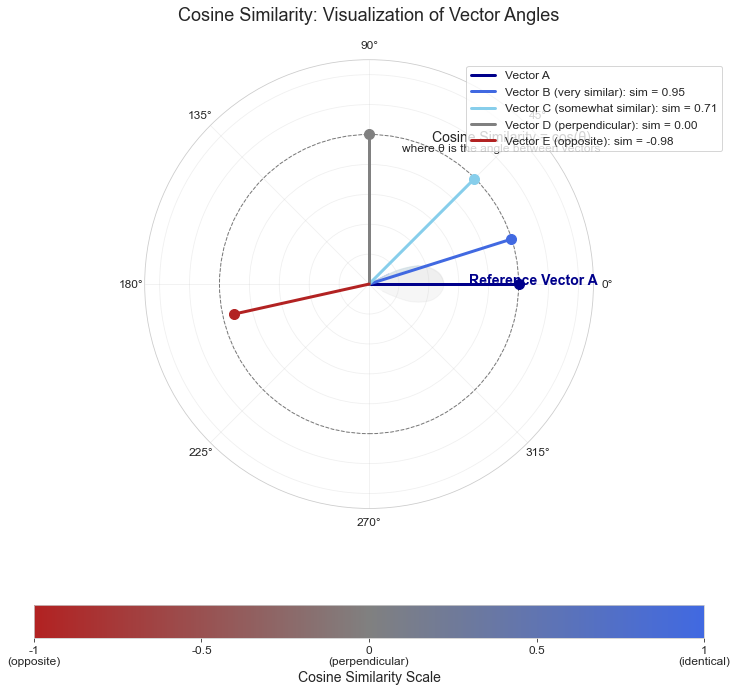

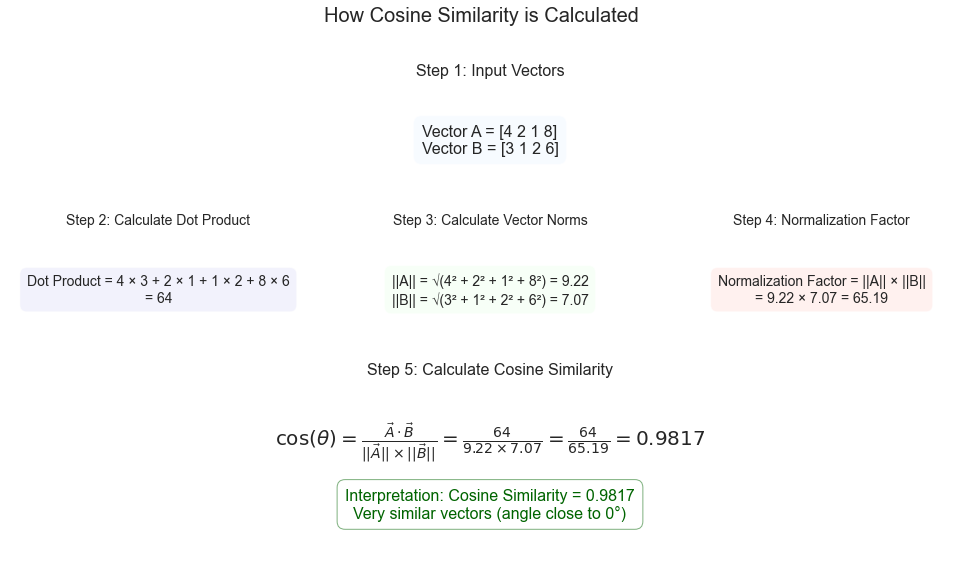

In [41]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from matplotlib.colors import LinearSegmentedColormap

# Set a consistent style for both plots - using direct seaborn styling
# instead of the outdated style name
sns.set_style("whitegrid")
plt.rcParams.update({
    'font.family': 'sans-serif',
    'font.sans-serif': ['Arial'],
    'font.size': 12,
    'axes.labelsize': 14,
    'axes.titlesize': 16,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12
})

# PLOT 1: Visual representation of cosine similarity between vectors in 2D space
plt.figure(figsize=(12, 10))

# Create some example vectors with different angles
vectors = [
    {'name': 'Vector A', 'coords': [1, 0], 'color': 'darkblue'},
    {'name': 'Vector B (very similar)', 'coords': [0.95, 0.3], 'color': 'royalblue'},
    {'name': 'Vector C (somewhat similar)', 'coords': [0.7, 0.7], 'color': 'skyblue'},
    {'name': 'Vector D (perpendicular)', 'coords': [0, 1], 'color': 'gray'},
    {'name': 'Vector E (opposite)', 'coords': [-0.9, -0.2], 'color': 'firebrick'}
]

# Calculate cosine similarities
reference_vector = np.array(vectors[0]['coords']).reshape(1, -1)
for v in vectors[1:]:
    v_array = np.array(v['coords']).reshape(1, -1)
    v['similarity'] = cosine_similarity(reference_vector, v_array)[0][0]

# Create the plot
ax = plt.subplot(111, projection='polar')
ax.set_theta_zero_location('E')  # Set 0 degrees to east (right side)

# Plot the reference vector and others
for v in vectors:
    # Convert Cartesian to polar
    x, y = v['coords']
    r = np.sqrt(x**2 + y**2)
    theta = np.arctan2(y, x)
    
    # Plot the vector
    ax.plot([0, theta], [0, r], '-', linewidth=3, color=v['color'], 
             label=f"{v['name']}{': sim = {:.2f}'.format(v['similarity']) if 'similarity' in v else ''}")
    
    # Plot a small point at the end of the vector
    ax.plot(theta, r, 'o', markersize=10, color=v['color'])

# Label the reference vector separately
ax.text(0, 1.1, "Reference Vector A", fontsize=14, ha='center', color='darkblue', weight='bold')

# Add shading for the angles
angle_vectors = vectors[1:]
for v in angle_vectors:
    x, y = v['coords']
    theta = np.arctan2(y, x)
    wedge_color = v['color'] if v['similarity'] > 0 else 'lightgray'
    wedge = patches.Wedge(center=(0, 0), r=0.5, theta1=0, theta2=np.degrees(theta), 
                          width=0.5, alpha=0.2, color=wedge_color)
    ax.add_patch(wedge)

# Set radial limits and remove radial ticks/grid
ax.set_rlim(0, 1.5)
ax.grid(True, alpha=0.3)
ax.set_yticklabels([])  # Hide radial tick labels

# Add a nice circular axis at r=1
circle = plt.Circle((0, 0), 1, transform=ax.transData._b, fill=False, linestyle='--', color='black', alpha=0.5)
ax.add_artist(circle)

# Add annotations
ax.text(np.pi/4, 1.35, "Cosine Similarity = cos(θ)", fontsize=14, ha='center')
ax.text(np.pi/4, 1.25, "where θ is the angle between vectors", fontsize=12, ha='center')

# Add a colorbar legend showing the similarity scale
cmap = LinearSegmentedColormap.from_list('sim_cmap', ['firebrick', 'gray', 'royalblue'])
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(-1, 1))
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, orientation='horizontal', pad=0.15, shrink=0.8)
cbar.set_label('Cosine Similarity Scale')
cbar.set_ticks([-1, -0.5, 0, 0.5, 1])
cbar.set_ticklabels(['-1\n(opposite)', '-0.5', '0\n(perpendicular)', '0.5', '1\n(identical)'])

# Add legend
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0))

plt.title('Cosine Similarity: Visualization of Vector Angles', fontsize=18, pad=20)
plt.tight_layout()
plt.savefig('cosine_similarity_vectors.png', dpi=300, bbox_inches='tight')
plt.show()

# PLOT 2: Step-by-step calculation visualization
plt.figure(figsize=(14, 8))

# Example vectors for calculation
vector_a = np.array([4, 2, 1, 8])
vector_b = np.array([3, 1, 2, 6])

# Calculate components for cosine similarity
dot_product = np.dot(vector_a, vector_b)
norm_a = np.linalg.norm(vector_a)
norm_b = np.linalg.norm(vector_b)
cosine_sim = dot_product / (norm_a * norm_b)

# Set up the plot grid
gs = plt.GridSpec(3, 3, height_ratios=[1, 1, 1.5])

# 1. Show the vectors
ax1 = plt.subplot(gs[0, :])
ax1.axis('off')
ax1.text(0.5, 0.5, 
         f"Vector A = {vector_a}\nVector B = {vector_b}", 
         ha='center', va='center', fontsize=16, 
         bbox=dict(boxstyle="round,pad=0.5", facecolor='aliceblue', alpha=0.5))
ax1.set_title("Step 1: Input Vectors", fontsize=16)

# 2. Show the dot product calculation
ax2 = plt.subplot(gs[1, 0])
ax2.axis('off')
dot_product_text = " + ".join([f"{a} × {b}" for a, b in zip(vector_a, vector_b)])
ax2.text(0.5, 0.5, 
         f"Dot Product = {dot_product_text}\n= {dot_product}", 
         ha='center', va='center', fontsize=14,
         bbox=dict(boxstyle="round,pad=0.5", facecolor='lavender', alpha=0.5))
ax2.set_title("Step 2: Calculate Dot Product", fontsize=14)

# 3. Calculate the norms
ax3 = plt.subplot(gs[1, 1])
ax3.axis('off')
norm_a_text = " + ".join([f"{a}²" for a in vector_a])
norm_b_text = " + ".join([f"{b}²" for b in vector_b])
ax3.text(0.5, 0.5, 
         f"||A|| = √({norm_a_text}) = {norm_a:.2f}\n||B|| = √({norm_b_text}) = {norm_b:.2f}", 
         ha='center', va='center', fontsize=14,
         bbox=dict(boxstyle="round,pad=0.5", facecolor='honeydew', alpha=0.5))
ax3.set_title("Step 3: Calculate Vector Norms", fontsize=14)

# 4. Calculate the normalization factor
ax4 = plt.subplot(gs[1, 2])
ax4.axis('off')
ax4.text(0.5, 0.5, 
         f"Normalization Factor = ||A|| × ||B||\n= {norm_a:.2f} × {norm_b:.2f} = {norm_a * norm_b:.2f}", 
         ha='center', va='center', fontsize=14,
         bbox=dict(boxstyle="round,pad=0.5", facecolor='mistyrose', alpha=0.5))
ax4.set_title("Step 4: Normalization Factor", fontsize=14)

# 5. Final formula and result
ax5 = plt.subplot(gs[2, :])
ax5.axis('off')

# Draw the formula with color-coded components
formula = r"$\cos(\theta) = \frac{\vec{A} \cdot \vec{B}}{||\vec{A}|| \times ||\vec{B}||} = \frac{%d}{%.2f \times %.2f} = \frac{%d}{%.2f} = %.4f$" % (
    dot_product, norm_a, norm_b, dot_product, norm_a * norm_b, cosine_sim)

ax5.text(0.5, 0.65, formula, ha='center', va='center', fontsize=20)

# Add the final interpretation
if cosine_sim > 0.9:
    interpretation = "Very similar vectors (angle close to 0°)"
    color = 'darkgreen'
elif cosine_sim > 0.5:
    interpretation = "Moderately similar vectors"
    color = 'green'
elif cosine_sim > 0:
    interpretation = "Somewhat similar vectors"
    color = 'olive'
elif cosine_sim == 0:
    interpretation = "Perpendicular vectors (90° angle)"
    color = 'gray'
else:
    interpretation = "Dissimilar vectors (angle > 90°)"
    color = 'darkred'

ax5.text(0.5, 0.3, 
         f"Interpretation: Cosine Similarity = {cosine_sim:.4f}\n{interpretation}", 
         ha='center', va='center', fontsize=16, color=color,
         bbox=dict(boxstyle="round,pad=0.5", facecolor='white', edgecolor=color, alpha=0.5))

ax5.set_title("Step 5: Calculate Cosine Similarity", fontsize=16)

# Main title
plt.suptitle("How Cosine Similarity is Calculated", fontsize=20, y=0.98)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig('cosine_similarity_calculation.png', dpi=300, bbox_inches='tight')
plt.show()